<div class="alert alert-block alert-info">
    <b>[2] is much better and more practical than [1].</b>
</div>

# Implementaion of [1]

- The paper's MSE is diffferent from our result. It is due to dephasing, which is represented by $\alpha$ and $\beta$.
- **This implementation assumes $\alpha=0$ and $\beta=1$.**

- **MSE is the average variance, not standard deviation.**

- The standard deviation informs how faithful is an estimation.

In [2]:
import numpy as np
from numpy import pi, cos, sin, sqrt, log, exp
from matplotlib import pyplot as plt
import statistics as stats
from scipy.optimize import minimize
from tqdm import tqdm
from multiprocessing import Pool

## Bayesian Estimation (n=1, m=1, 2, ..., N)

In [2]:
N = 50

f0 = 120e6
w0 = 2 * pi * f0
tau = pi/w0/1.5
alpha = 0
beta = 1

# Trigonometric polynomial of the coin probability

def tripoly1sample(r, m):
    lst = [0] * (2*m + 1)
    lst[0] = r * beta * 1/2
    lst[2*m] = r * beta * 1/2
    lst[m] = 1 + alpha
    
    return np.poly1d(lst)

def toss(m):
    p = .5*(1 + alpha + beta * cos(w0 * m * tau))
    return np.random.choice([1, -1], p=[p, 1-p])

# ml = list(range(1, N+1))
ml = [round((1.1)**i) for i in range(1, N+1)]
# ml = list(range(1, (N+1)//3))*3
rl = [toss(m) for m in ml]

tripolyN = 1
for m, r in zip (ml, rl):
    tripolyN *= tripoly1sample(r, m)
    
coeff = tripolyN.c
M = (len(coeff)-1)//2
coeff = np.divide(coeff, coeff[M])

coeff_avg = []
for n in range(-M, M+1):
    if n == 0:
        coeff_avg.append(pi/2)
    else:
        coeff_avg.append(((-1)**n-1)/n**2/pi)

coeff_sqavg = []
for n in range(-M, M+1):
    if n == 0:
        coeff_sqavg.append(pi**2/3)
    else:
        coeff_sqavg.append((-1)**n*2/n**2)

avg = np.dot(coeff, coeff_avg)/2/pi/tau
sqavg = np.dot(coeff, coeff_sqavg)/(2*pi*tau)**2
sd = sqrt(sqavg-avg**2)

print(f"Avg: {avg/1e6:.6f}")
print(f"Std: {sd/1e6:.6f}")

Avg: 120.360141
Std: 0.239942


## Fluctuating $f$

In [3]:
N = 50

f0 = 100e6
w0 = 2 * pi * f0
tau = pi/w0/1.5
alpha = 0
beta = 1
sdf = .115e6 * 2
sdw = sdf * 2 * pi

# Trigonometric polynomial of the coin probability

def tripoly1sample(r, m):
    lst = [0] * (2*m + 1)
    lst[0] = r * beta * 1/2
    lst[2*m] = r * beta * 1/2
    lst[m] = 1 + alpha
    
    return np.poly1d(lst)

def toss(m):
    p = .5*(1 + alpha + beta * cos(w0 * m * tau))
    return np.random.choice([1, -1], p=[p, 1-p])

# ml = list(range(1, N+1))
ml = [round((1.1)**i) for i in range(1, N+1)]
rl = []
# ml = list(range(1, (N+1)//3))*3
for m in ml:
    rl.append(toss(m))
    w0 += np.random.normal(scale=sdw)   

tripolyN = 1
for m, r in zip (ml, rl):
    tripolyN *= tripoly1sample(r, m)
    
coeff = tripolyN.c
M = (len(coeff)-1)//2
coeff = np.divide(coeff, coeff[M])

coeff_avg = []
for n in range(-M, M+1):
    if n == 0:
        coeff_avg.append(pi/2)
    else:
        coeff_avg.append(((-1)**n-1)/n**2/pi)

coeff_sqavg = []
for n in range(-M, M+1):
    if n == 0:
        coeff_sqavg.append(pi**2/3)
    else:
        coeff_sqavg.append((-1)**n*2/n**2)

avg = np.dot(coeff, coeff_avg)/2/pi/tau
sqavg = np.dot(coeff, coeff_sqavg)/(2*pi*tau)**2
sd = sqrt(sqavg-avg**2)

print(f"True: {w0/2/pi/1e6:.6f}")
print(f"Avg: {avg/1e6:.6f}")
print(f"Std: {sd/1e6:.6f}")

True: 99.993287
Avg: 99.651798
Std: 0.185665


# Implementation of [2]

- Coin probability: $P(r\vert\omega,t)=\frac{1}{2}(1+\cos\omega t)$
- We assume prior $\omega\sim\mathcal{N}(\mu,\sigma^2)$ and update it using mean and variation given by posteiror.
- We don't restrict a range for $\omega$ but arbitrary set an initial prior.
- **This implementation assumes $\alpha=0$ and $\beta=1$.**

In [4]:
import numpy as np
from numpy import pi, cos, sin, sqrt, log, exp
from matplotlib import pyplot as plt
import statistics as stats
from tqdm import tqdm

Avg: 104.761639
Std: 0.547264


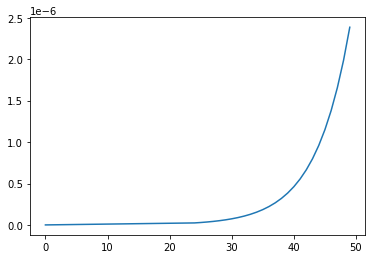

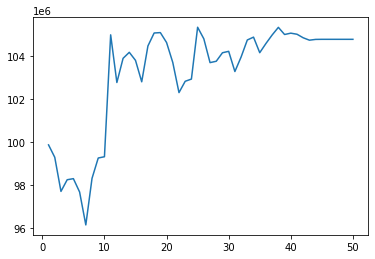

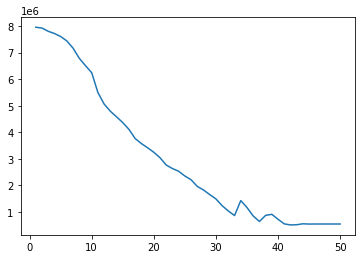

In [5]:
N = 50

f0 = 105e6
w0 = 2 * pi * f0
alpha = 0
beta = 1

def toss(t):
    p = .5*(1 + alpha + beta * cos(w0 * t))
    return np.random.choice([1, -1], p=[p, 1-p])

init_f = 100e6
mu = 2 * pi * init_f
init_sd = 50e6
var = init_sd**2

# tl = np.linspace(1e-9, N*1e-9, N)
# tl = [1.12**i*1/4/init_f for i in range(1, N+1)]


# Hybrid approach (Linear + exponential distribution of t's)

# This is an ad-hoc solution optimized for N=50
N = 50
tl = list(np.linspace(1e-9, N/2*1e-9, N//2))
tl +=  [10*1.2**i*1/4/init_f for i in range(1, N//2+1)]

# This is not optimized.
# N = 30
# tl = list(np.linspace(1e-9, N/2*1e-9, 25))
# tl +=  [6*1.25**i*1/4/init_f for i in range(1, 6)]


rl = [toss(t) for t in tl]
fl = []
fsdl = []

for t, r in zip(tl, rl):
    #print(f"{r}, {mu/1e6:.2f}, {sqrt(var)/1e6:.2f}")
    
    e = exp(-.5*var*t**2)

    new_mu = mu - (r * var * t * sin(mu*t) * e)/(1 + r * cos(mu*t) * e)
    new_var = var - r * var**2 * t**2 * e * (cos(mu*t) + r * e)/(1 + r * cos(mu*t) * e)**2
    
    mu = new_mu
    var = new_var
    
    fl.append(mu/2/pi)
    fsdl.append(sqrt(var)/2/pi)
    
print(f"Avg: {mu/2/pi/1e6:.6f}")
print(f"Std: {sqrt(var)/2/pi/1e6:.6f}")

plt.plot(range(len(tl)), tl)
plt.show()
plt.plot(range(1, N+1), fl)
plt.ticklabel_format(axis='y', scilimits=(6, 6))
plt.show()
plt.plot(range(1, N+1), fsdl)
plt.ticklabel_format(axis='y', scilimits=(6, 6))
plt.show()

## Adaptive Method

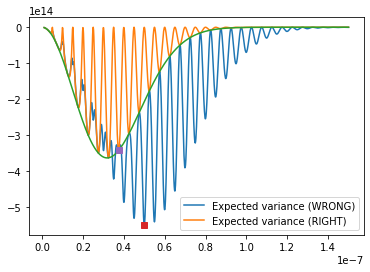

In [6]:
N = 1000

alpha = 0
beta = 1

init_f = 100e6
mu = 2 * pi * init_f
init_sdf = 5e6
var = (init_sdf*2*pi)**2

def coin_prob(t, r):
    return .5*(1 + r * (alpha + beta * cos(mu * t)))

def new_var(t, r):
    e = exp(-.5*var*t**2)
    return - r * var**2 * t**2 * e * (cos(mu*t) + r*e)/(1 + r * cos(mu*t) * e)**2

def new_var2(t):
    e = exp(-.5*var*t**2)
    return -var**2*t**2*sin(mu*t)**2/(e**(-2)-cos(mu*t)**2)

def envelope(t):
    return -var**2*t**2*exp(-t**2*var)

tl = np.linspace(1e-9, 150e-9, N)
varl = [sum([coin_prob(t, r) * new_var(t, r) for r in [-1, 1]]) for t in tl]
var2l = [new_var2(t) for t in tl]
envl = [envelope(t) for t in tl]

plt.plot(tl, varl, label='Expected variance (WRONG)')
plt.plot(tl, var2l, label='Expected variance (RIGHT)')

plt.plot(tl, envl)
x = pi/mu*round(mu/pi*1.599/sqrt(var))
y = sum([coin_prob(x, r) * new_var(x, r) for r in [-1, 1]])
plt.plot(x, y, 's')
k = round(mu/pi/sqrt(var)+.5)
t = (k+.5)*pi/mu
y = new_var2(t)
plt.plot(t, y, 's')
plt.legend()
plt.show()

<div class="alert alert-block alert-success">
<b>IT WORKS!!</b> 
</div>

Avg: 104.99998848035845
Std: 5.467671267528046e-05


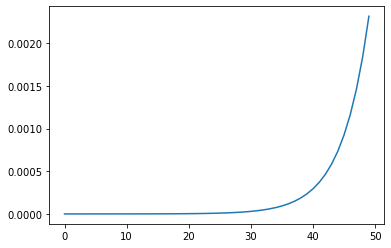

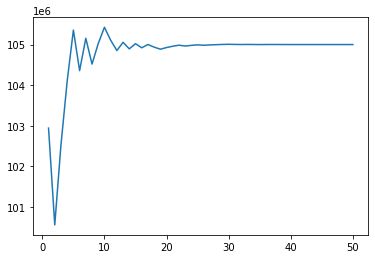

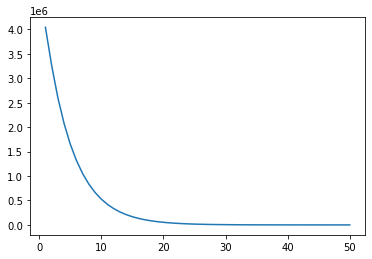

In [7]:
N = 50

f0 = 105e6
w0 = 2 * pi * f0
alpha = 0
beta = 1

def toss(t):
    p = .5*(1 + alpha + beta * cos(w0 * t))
    return np.random.choice([1, -1], p=[p, 1-p])

init_f = 100e6
mu = 2 * pi * init_f
init_sdf = 5e6
var = (init_sdf*2*pi)**2

tl = []
rl = []
fl = []
fsdl = []

for _ in range(N):
    k = round(mu/pi/sqrt(var)+.5)
    t = (k+.5)*pi/mu
    r = toss(t)
    tl.append(t)
    rl.append(r)
    
    e = exp(-.5*var*t**2)
    
    new_mu = mu - (r * var * t * sin(mu*t) * e)/(1 + r * cos(mu*t) * e)
    new_var = var - r * var**2 * t**2 * e * (cos(mu*t) + r * e)/(1 + r * cos(mu*t) * e)**2
    
    mu = new_mu
    var = new_var
    
    fl.append(mu/2/pi)
    fsdl.append(sqrt(var)/2/pi)
    
print(f"Avg: {mu/2/pi/1e6}")
print(f"Std: {sqrt(var)/2/pi/1e6}")

plt.plot(range(len(tl)), tl)
plt.show()
plt.plot(range(1, N+1), fl)
plt.ticklabel_format(axis='y', scilimits=(6, 6))
plt.show()
plt.plot(range(1, N+1), fsdl)
plt.ticklabel_format(axis='y', scilimits=(6, 6))
plt.show()

# Implementation of [2] considering dephasing

- Coin probability: $P(r\vert\omega,t)=\frac{1}{2}(1+\cos\omega t)$
- We assume prior $\omega\sim\mathcal{N}(\mu,\sigma^2)$ and update it using mean and variation given by posteiror.
- We don't restrict a range for $\omega$ but arbitrary set an initial prior.
- **This implementation does not assume $\alpha=0$ and $\beta=1$.**

## Adaptive method


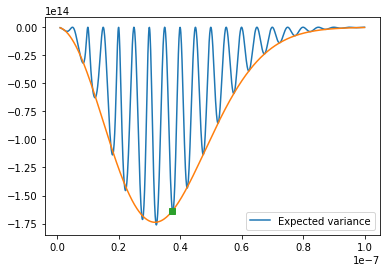

In [8]:
N = 1000

alpha = 0.25
beta = 0.67

init_f = 100e6
mu = 2 * pi * init_f
init_sdf = 5e6
var = (init_sdf*2*pi)**2

def new_var(t):
    e = exp(-.5*var*t**2)
    return -(beta*t*var*e)**2*sin(mu*t)**2/(1-(alpha+beta*cos(mu*t)*e)**2)

def envelope(t):
    return -var**2*t**2*exp(-t**2*var)/(1-alpha**2)*beta**2

tl = np.linspace(1e-9, 100*1e-9, N)
varl = [new_var(t) for t in tl]
envl = [envelope(t) for t in tl]

plt.plot(tl, varl, label='Expected variance')
plt.plot(tl, envl)

k = round(mu/pi/sqrt(var)+.5)
t = (k+.5)*pi/mu
y = new_var(t)
plt.plot(t, y, 's')

plt.legend()
plt.show()

Avg: 105.11325670352934
Std: 0.2633589469623785


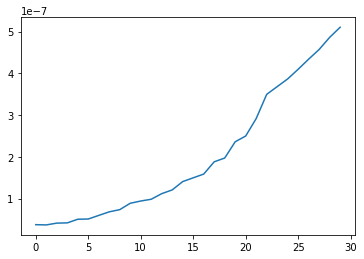

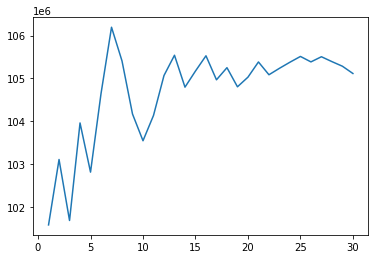

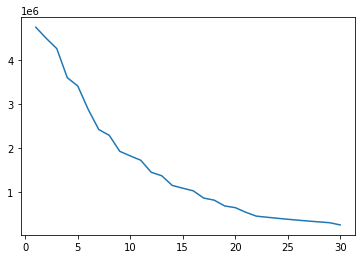

In [9]:
N = 30

f0 = 105e6
w0 = 2 * pi * f0
alpha = 0.25
beta = 0.67

def toss(t):
    p = .5*(1 + alpha + beta * cos(w0 * t))
    return np.random.choice([1, -1], p=[p, 1-p])

init_f = 100e6
mu = 2 * pi * init_f
init_sdf = 5e6
var = (init_sdf*2*pi)**2

tl = []
rl = []
fl = []
fsdl = []

for _ in range(N):
    k = round(mu/pi/sqrt(var)+.5)
    t = (k+.5)*pi/mu
    r = toss(t)
    tl.append(t)
    rl.append(r)
    
    e = exp(-.5*var*t**2)
    
    new_mu = mu - (r * beta * var * t * sin(mu*t) * e)/(1 + r * alpha + r * beta * cos(mu*t) * e)
    new_var = var - r * beta * var**2 * t**2 * e * ((1+r*alpha)*cos(mu*t) + r*beta*e)/(1+r*alpha + r*beta*cos(mu*t)*e)**2
    
    mu = new_mu
    var = new_var
    
    fl.append(mu/2/pi)
    fsdl.append(sqrt(var)/2/pi)
    
print(f"Avg: {mu/2/pi/1e6}")
print(f"Std: {sqrt(var)/2/pi/1e6}")

plt.plot(range(len(tl)), tl)
plt.show()
plt.plot(range(1, N+1), fl)
plt.ticklabel_format(axis='y', scilimits=(6, 6))
plt.show()
plt.plot(range(1, N+1), fsdl)
plt.ticklabel_format(axis='y', scilimits=(6, 6))
plt.show()

# Fluctuating $f$ following Brownian motion

## Adaptive method on fluctuating $f$ following [2]

Avg: 90.03018212625493
Std: 0.9349506797289453
MSE: 3.0862177078557558


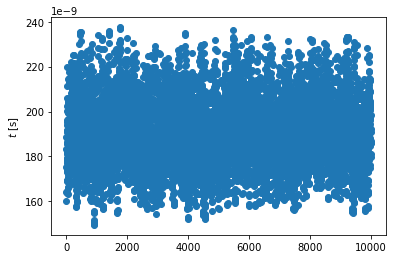

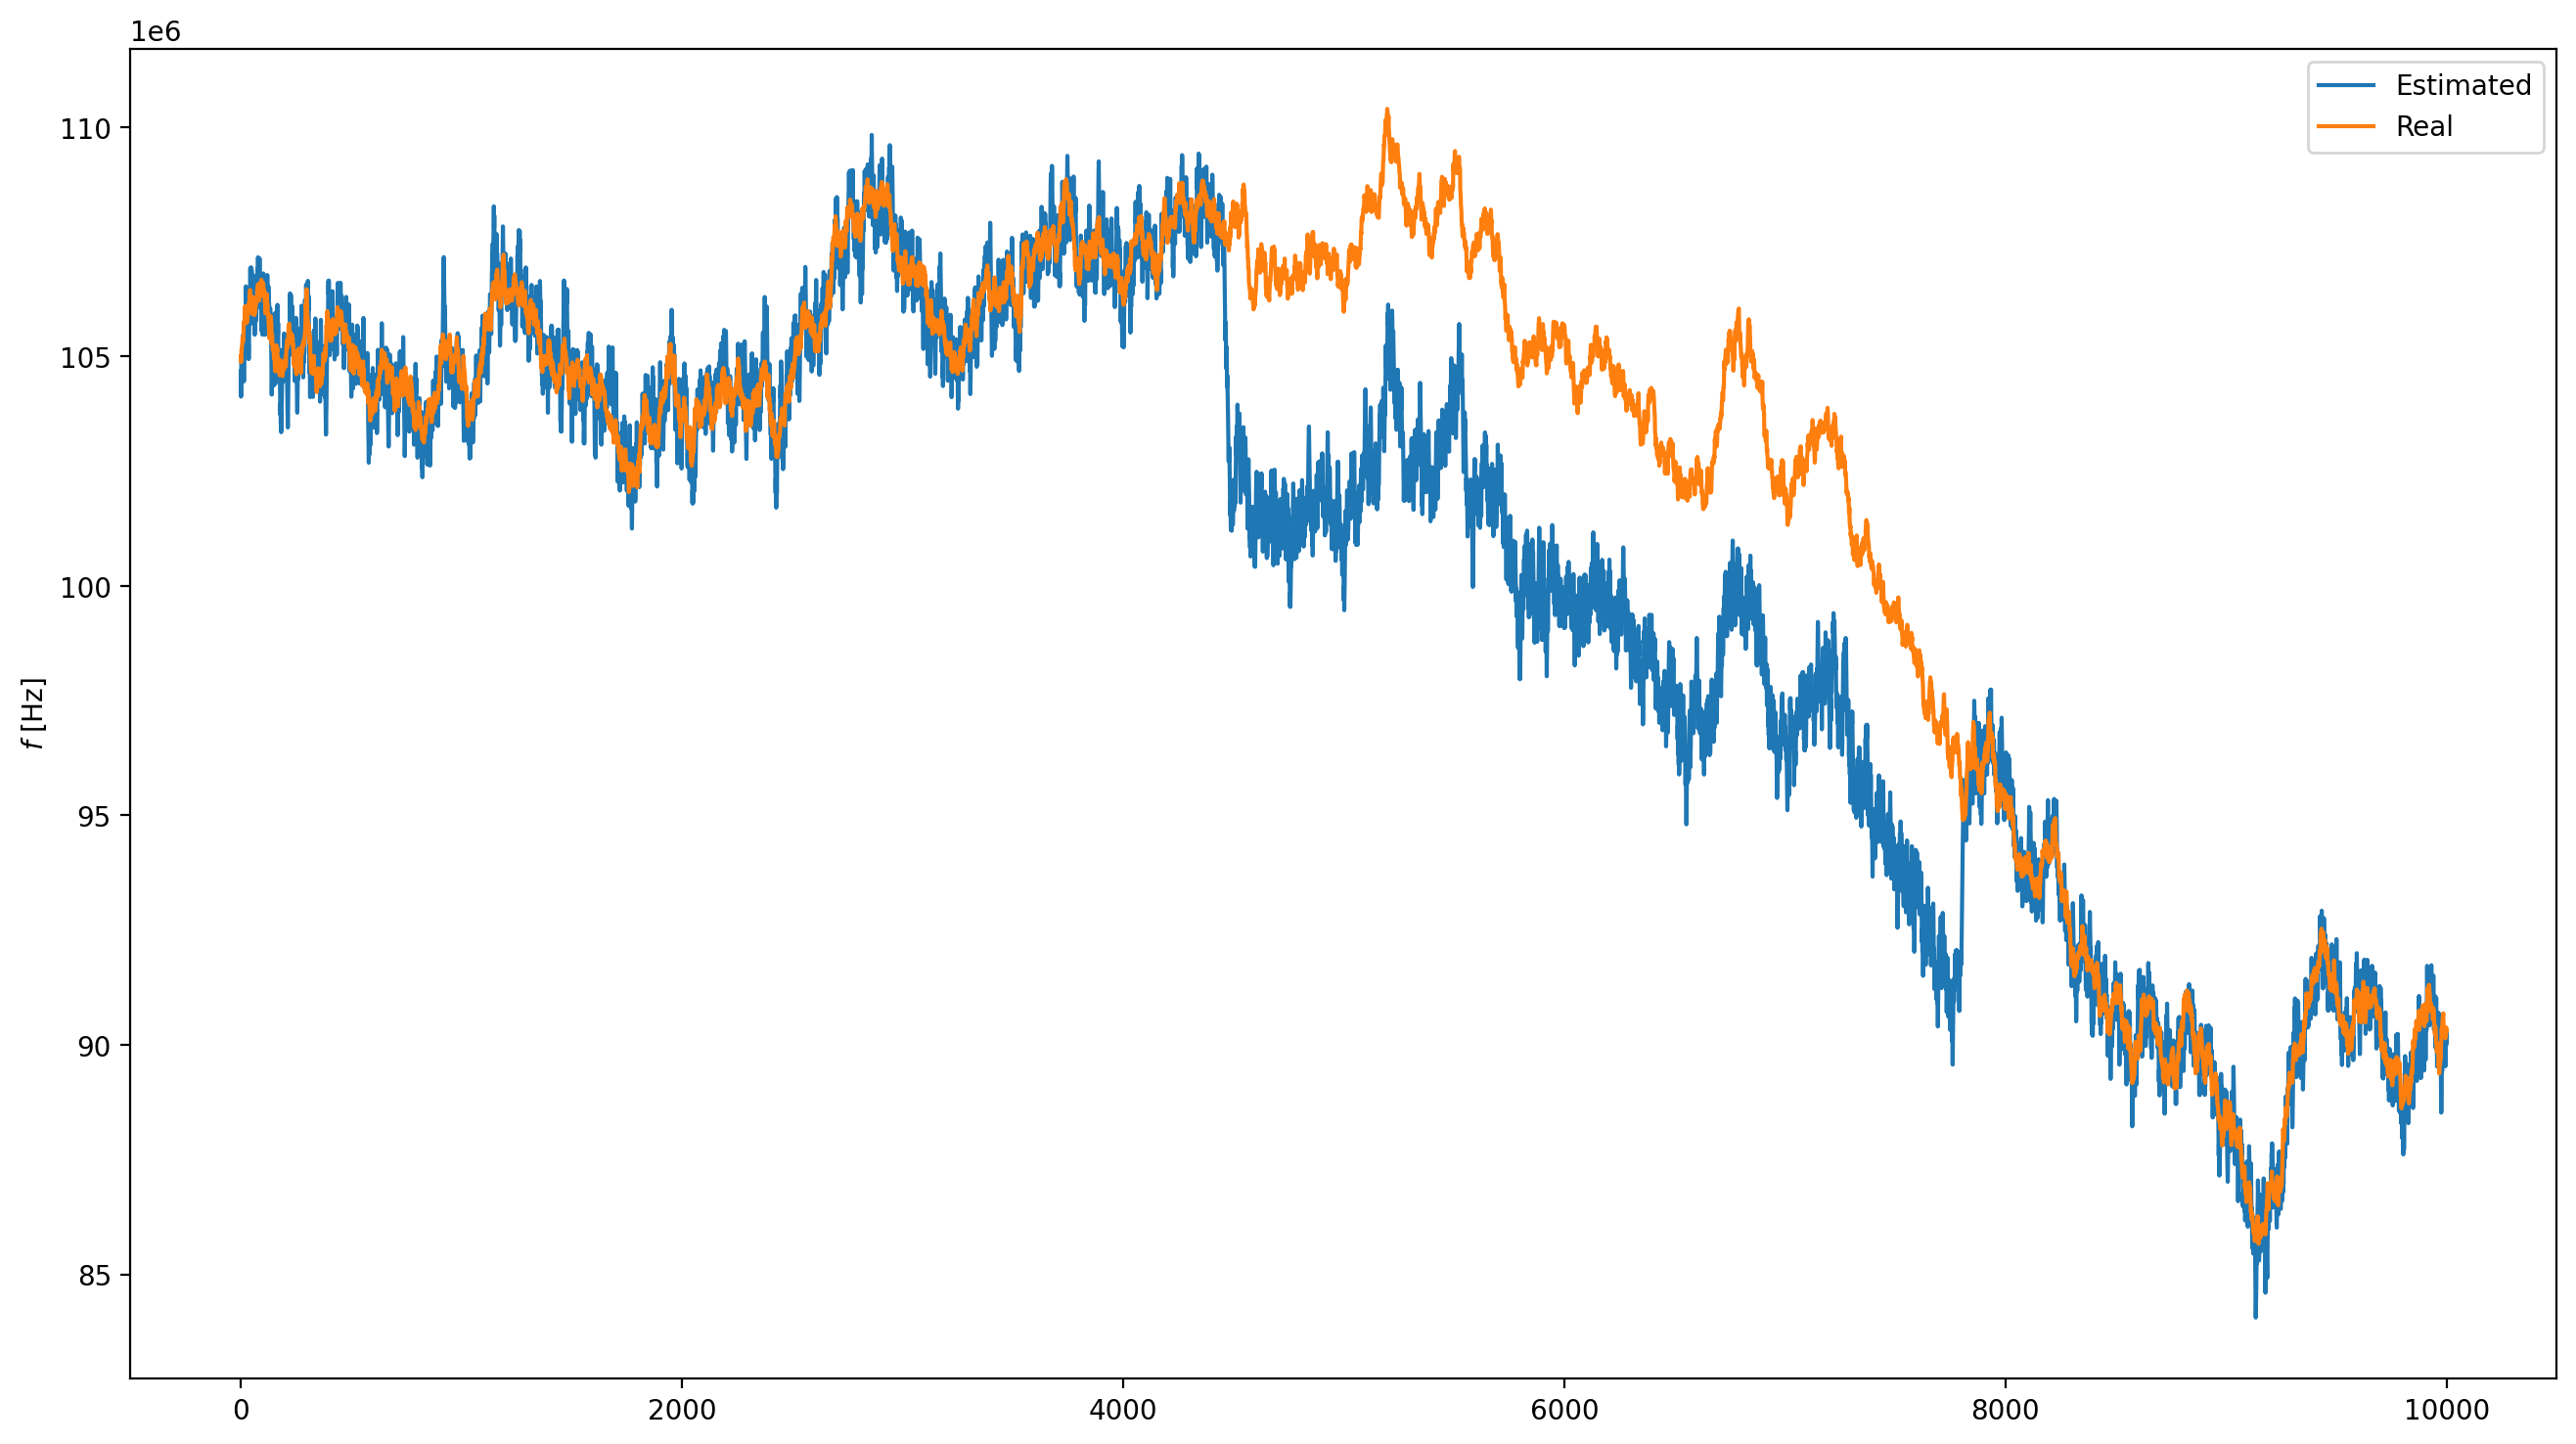

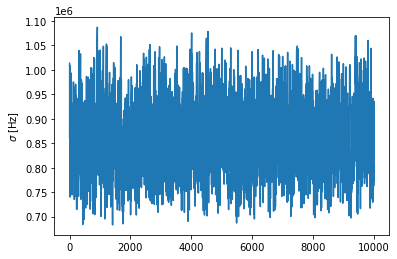

In [10]:
N = 10000

f0 = 105e6
w0 = 2 * pi * f0
sdf0 = .115e6
sdw = 2 * pi * sdf0
alpha = 0.25
beta = 0.67

def toss(t):
    p = .5*(1 + alpha + beta * cos(w * t))
    return np.random.choice([1, -1], p=[p, 1-p])

w = 2 * pi * f0
mu = 2 * pi * f0
init_sdf = 1e6
var = (init_sdf*2*pi)**2

tl = []
rl = []
fl = []
realfl = []
fsdl = []

mse = 0

for _ in range(N):
    k = round(mu/pi/sqrt(var)+.5)
    t = (k+.5)*pi/mu
    r = toss(t)
    tl.append(t)
    rl.append(r)
    
    e = exp(-.5*var*t**2)
    
    new_mu = mu - (r * beta * var * t * sin(mu*t) * e)/(1 + r * alpha + r * beta * cos(mu*t) * e)
    new_var = var - r * beta * var**2 * t**2 * e * ((1+r*alpha)*cos(mu*t) + r*beta*e)/(1+r*alpha + r*beta*cos(mu*t)*e)**2
    
    mu = new_mu
    var = new_var + (sdw ** 2) * 10
    
    
    fl.append(mu/2/pi)
    realfl.append(w/2/pi)
    fsdl.append(sqrt(var)/2/pi)
    mse += (w-mu)**2
    
    w += np.random.normal(scale=sdw)
    
print(f"Avg: {mu/2/pi/1e6}")
print(f"Std: {sqrt(var)/2/pi/1e6}")
print(f"MSE: {sqrt(mse/N)/2/pi/1e6}")

plt.plot(range(len(tl)), tl, 'o')
plt.ticklabel_format(axis='y', scilimits=(-9, -9))
plt.ylabel("$t$ [s]")
plt.show()
plt.figure(figsize=(16, 9), dpi=200)
plt.plot(range(1, N+1), fl, label='Estimated')
plt.plot(range(1, N+1), realfl, label='Real')
plt.legend()
plt.ticklabel_format(axis='y', scilimits=(6, 6))
plt.ylabel("$f$ [Hz]")
plt.show()
plt.plot(range(1, N+1), fsdl)
plt.ticklabel_format(axis='y', scilimits=(6, 6))
plt.ylabel("$\sigma$ [Hz]")
plt.show()

## Hybrid Bayesian #1

- Possibility of hybrid model is proved here (Block Bayesian + Optimized Bayesian)
- The factor K in `var = var_new + (sdw ** 2) * K` can be further optimized.
- Estimate only on 2k-th trials.

Avg: 102.33511208171929
Std: 0.47136067954711486
MSE: 3.129480582914504


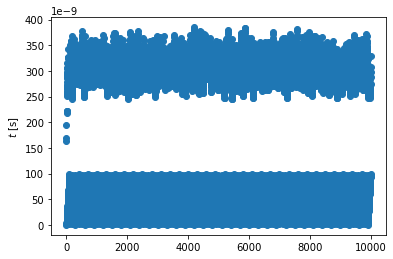

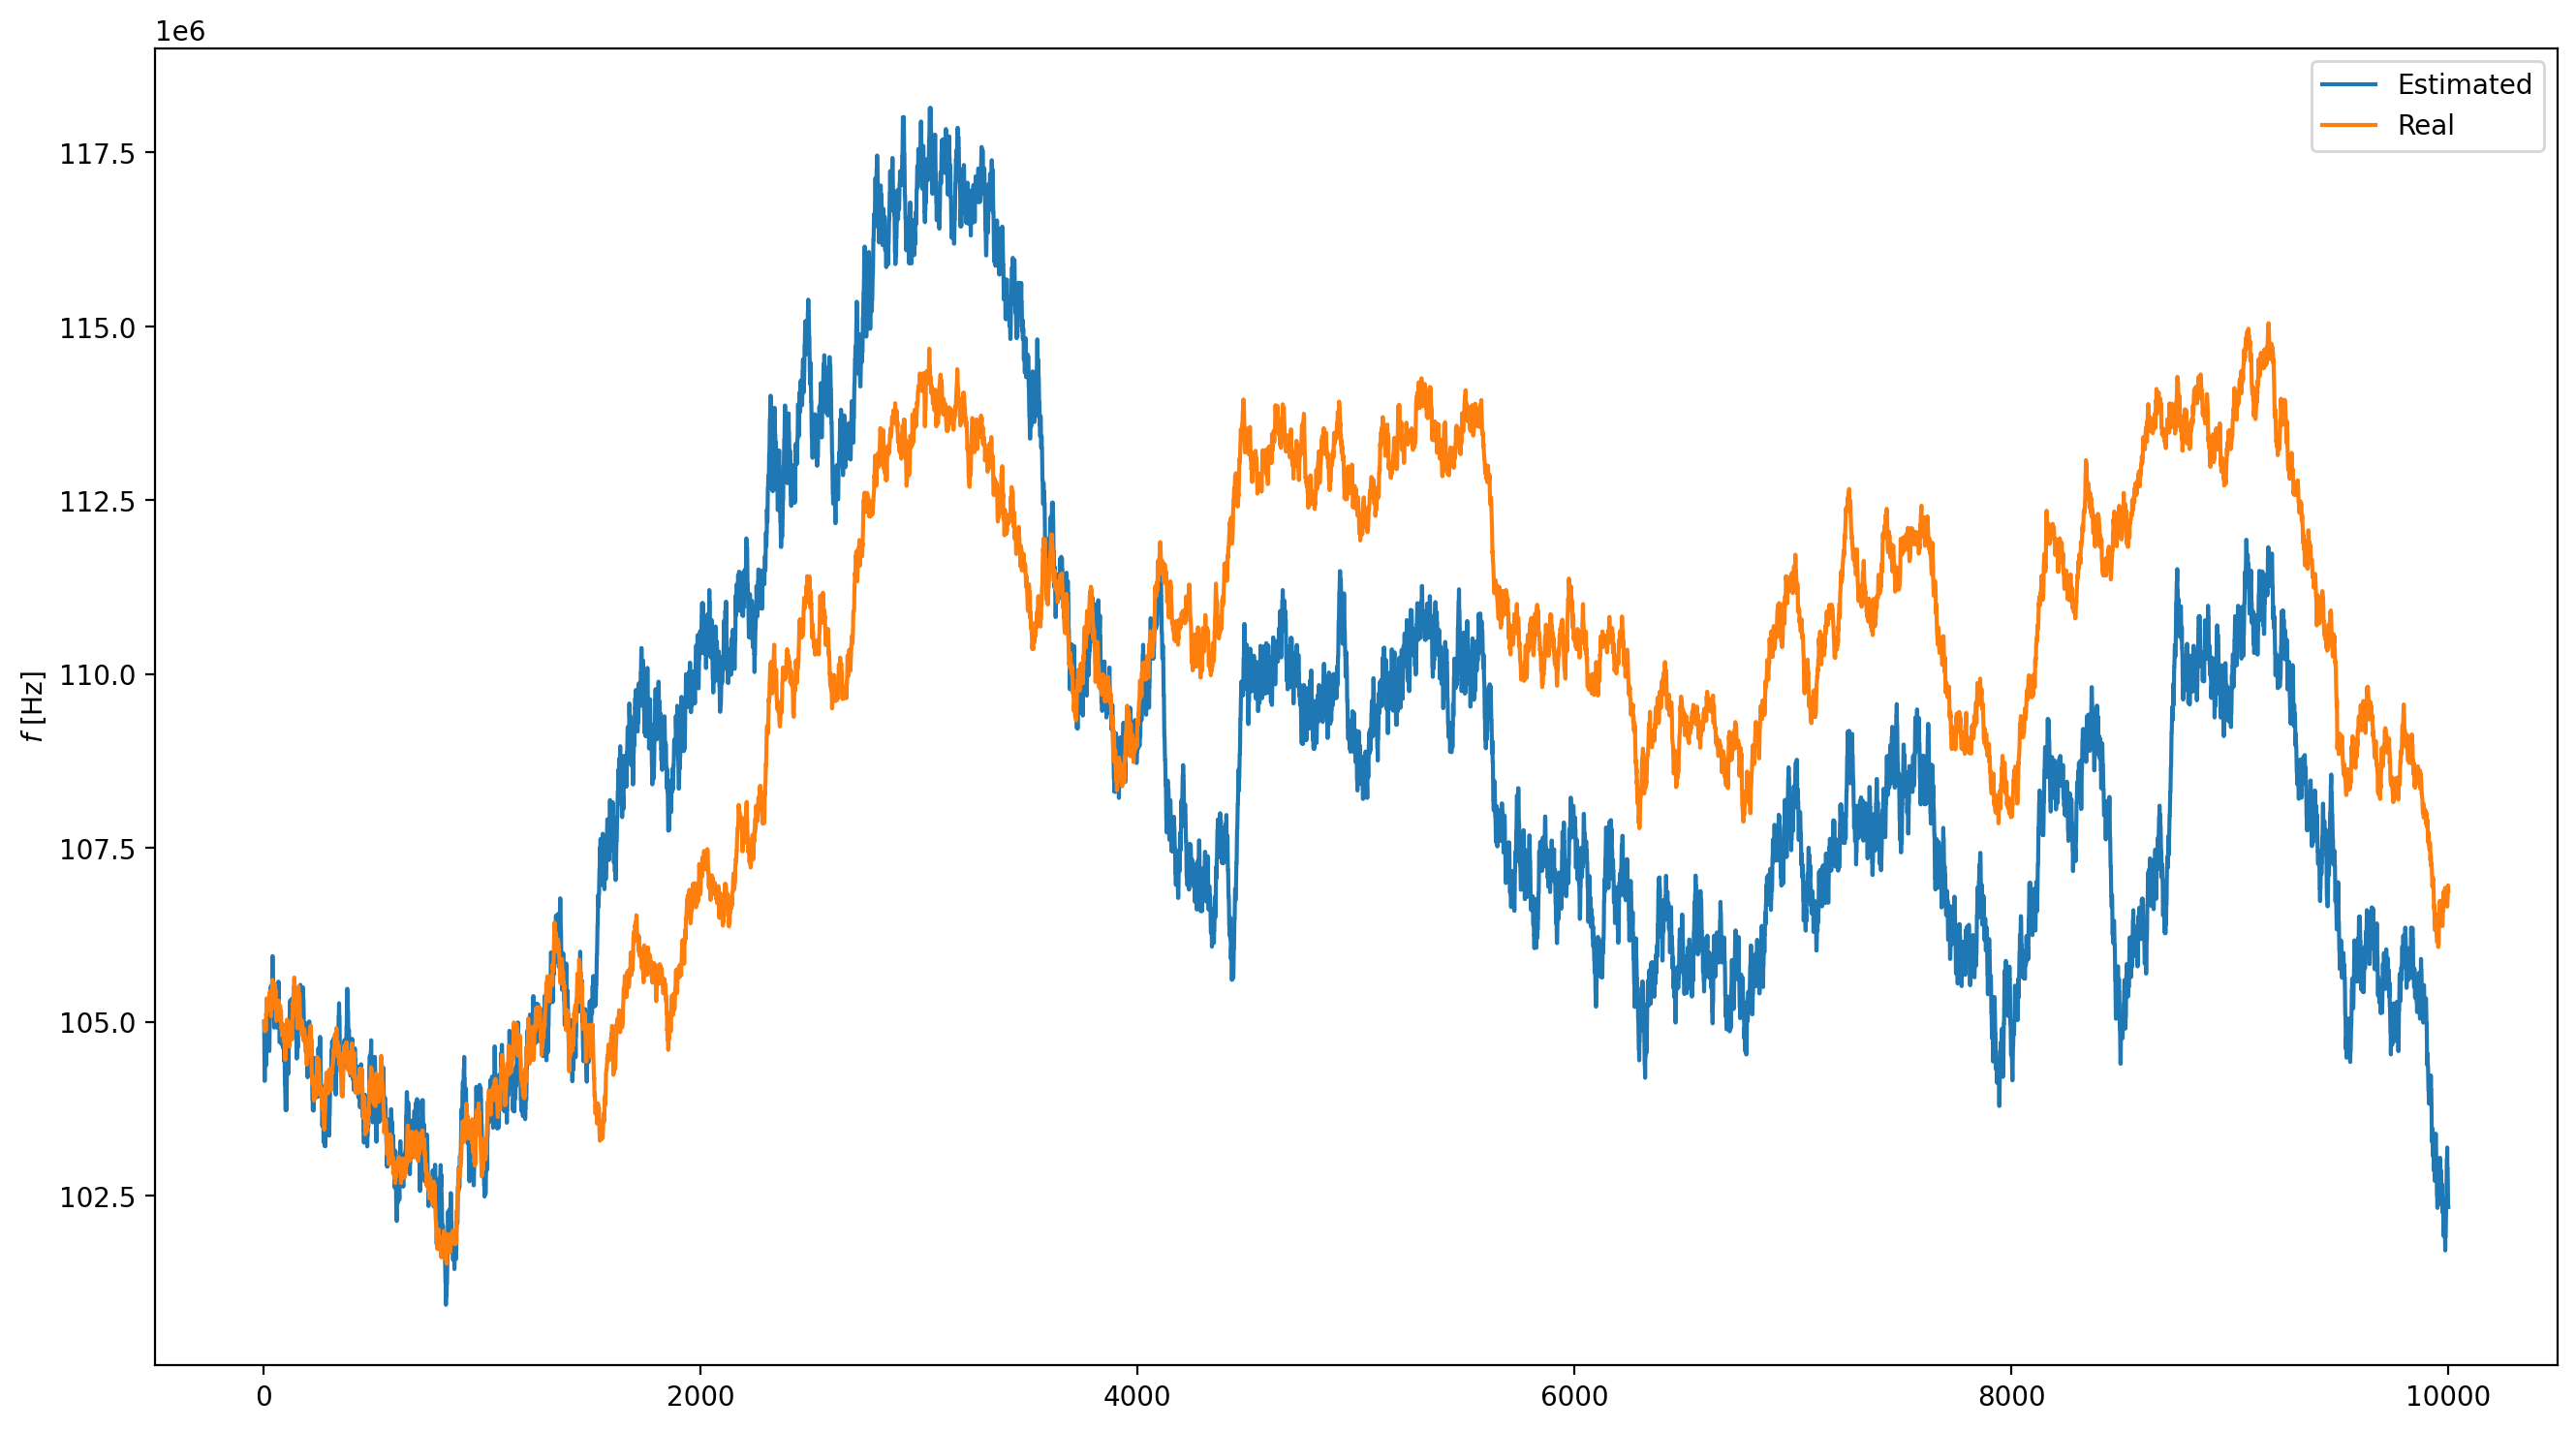

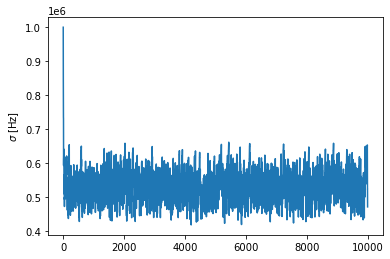

In [11]:
N = 10000

f0 = 105e6
w0 = 2 * pi * f0
sdf0 = .1e6
sdw = 2 * pi * sdf0
alpha = 0.25
beta = 0.67

def toss(t):
    p = .5*(1 + alpha + beta * cos(w * t))
    return np.random.choice([1, -1], p=[p, 1-p])

w = 2 * pi * f0
mu = 2 * pi * f0
init_sdf = 1e6
var = (init_sdf*2*pi)**2

tl = []
rl = []
fl = []
realfl = []
fsdl = []

mse = 0

for _ in range(N):
    if _%3 != 0:
        k = round(mu/pi/sqrt(var)+.5)
        t = (k+.5)*pi/mu
        r = toss(t)
        tl.append(t)
        rl.append(r)

        e = exp(-.5*var*t**2)

        new_mu = mu - (r * beta * var * t * sin(mu*t) * e)/(1 + r * alpha + r * beta * cos(mu*t) * e)
        new_var = var - r * beta * var**2 * t**2 * e * ((1+r*alpha)*cos(mu*t) + r*beta*e)/(1+r*alpha + r*beta*cos(mu*t)*e)**2

        mu = new_mu
        var = new_var + (sdw ** 2) * 5
    
    else:
        tl.append(_ % 100 * 1e-9)
        
    fl.append(mu/2/pi)
    realfl.append(w/2/pi)
    fsdl.append(sqrt(var)/2/pi)
   
    mse += (w-mu)**2
    
    w += np.random.normal(scale=sdw)
    
print(f"Avg: {mu/2/pi/1e6}")
print(f"Std: {sqrt(var)/2/pi/1e6}")
print(f"MSE: {sqrt(mse/N)/2/pi/1e6}")

plt.plot(range(len(tl)), tl, 'o')
plt.ticklabel_format(axis='y', scilimits=(-9, -9))
plt.ylabel("$t$ [s]")
plt.show()
plt.figure(figsize=(16, 9), dpi=200)
plt.plot(range(1, N+1), fl, label='Estimated')
plt.plot(range(1, N+1), realfl, label='Real')
plt.legend()
plt.ticklabel_format(axis='y', scilimits=(6, 6))
plt.ylabel("$f$ [Hz]")
plt.show()
plt.plot(range(1, N+1), fsdl)
plt.ticklabel_format(axis='y', scilimits=(6, 6))
plt.ylabel("$\sigma$ [Hz]")
plt.show()

## Hybrid Bayesian #2

- Block Bayesian + Opt Bayesian[2]
- Adaptable parameters: 1) Step SD multiplicating param. and 2) Ouch param.

Ouch: 9493
Avg: 110.03536907206232
Std: 0.9148719882366184
MSE: 0.7512656298613695
BlockMSE: 1.5811293545857745


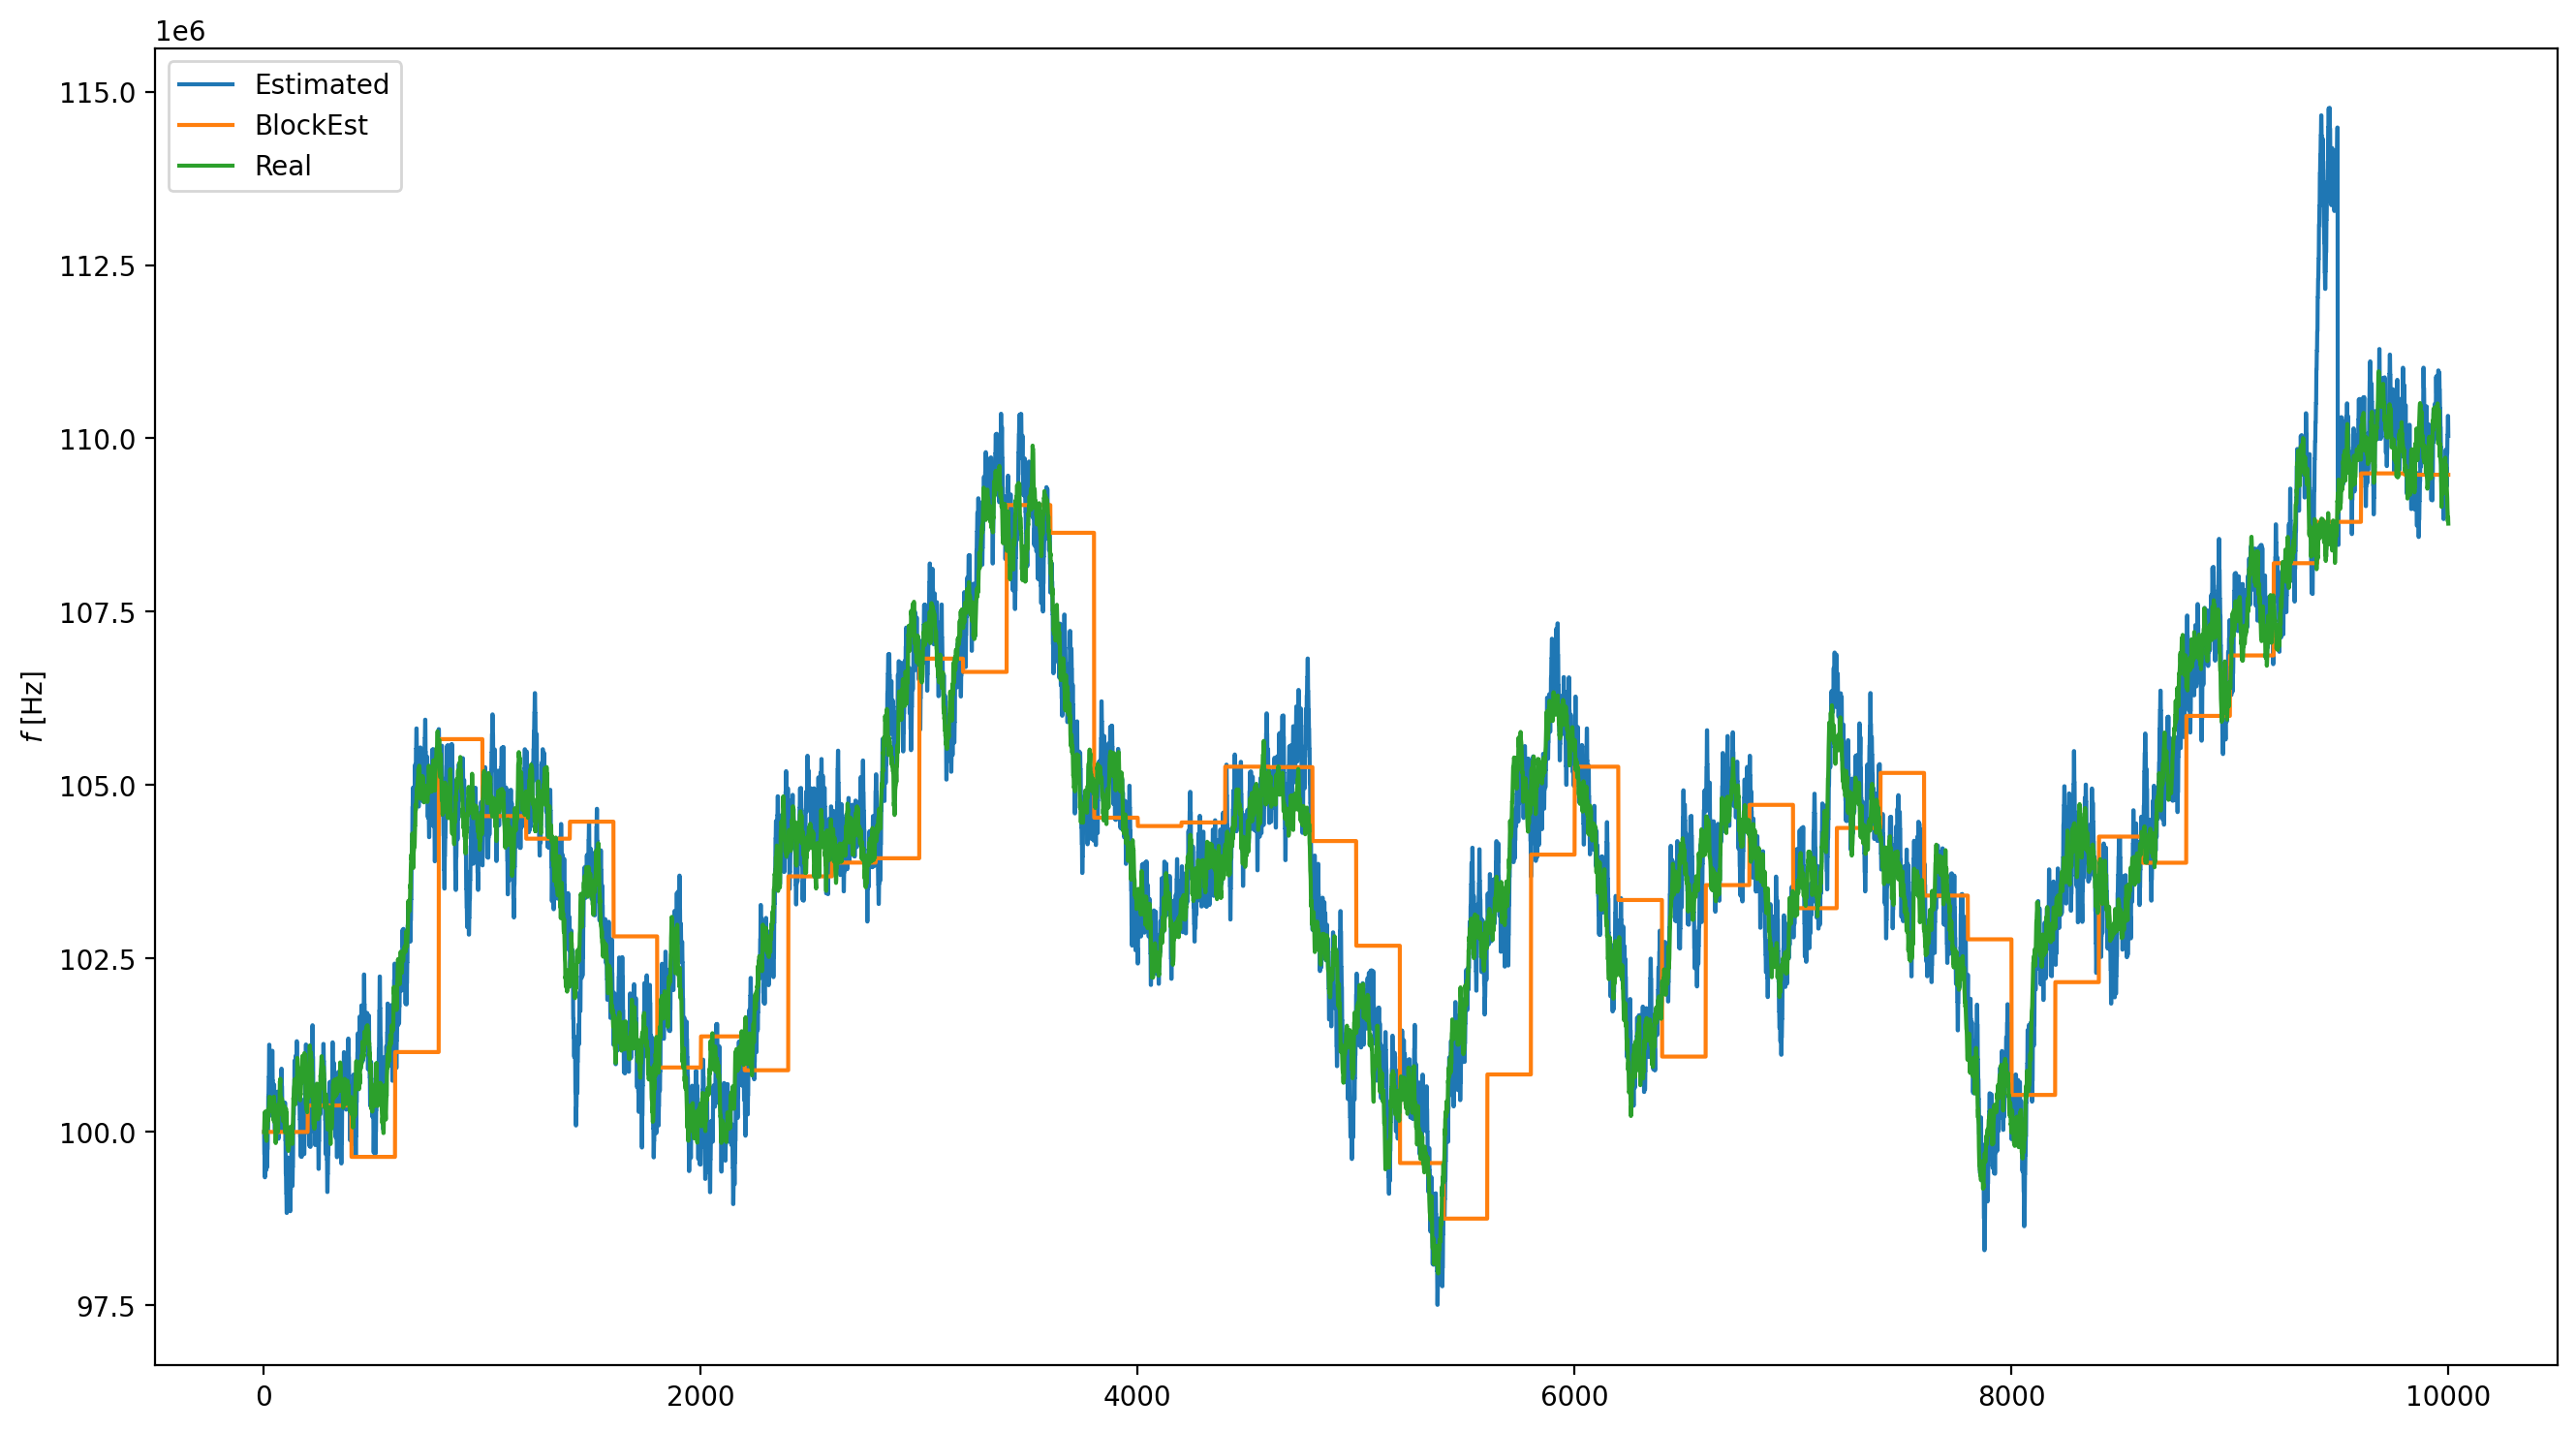

In [12]:
N = 10000

f0 = 100e6
w0 = 2 * pi * f0
sdf0 = .115e6
sdw = 2 * pi * sdf0
alpha = 0.25
beta = 0.67

def toss(t):
    p = .5*(1 + alpha + beta * cos(w * t))
    return np.random.choice([1, -1], p=[p, 1-p])

w = 2 * pi * f0
mu = 2 * pi * f0
block_mu = 2 * pi * f0
init_sdf = 1e6
var = (init_sdf*2*pi)**2

tl = []
rl = []
fl = []
block_fl = []
realfl = []
fsdl = []

msew = 0
block_msew = 0

M = 100
block_count = 0
block_tl = []
block_rl = []

for _ in range(N):
    if _%2 != 0:
        k = round(mu/pi/sqrt(var)+.5)
        t = (k+.5)*pi/mu
        r = toss(t)

        e = exp(-.5*var*t**2)

        new_mu = mu - (r * beta * var * t * sin(mu*t) * e)/(1 + r * alpha + r * beta * cos(mu*t) * e)
        new_var = var - r * beta * var**2 * t**2 * e * ((1+r*alpha)*cos(mu*t) + r*beta*e)/(1+r*alpha + r*beta*cos(mu*t)*e)**2

        mu = new_mu
        var = new_var + (sdw ** 2) * 10
        
        if np.abs(mu - block_mu) > 1e6*2*pi * 6:
            print(f"Ouch: {_}")
            mu = block_mu
    
    else:
        block_count %= M
        if len(block_tl) == M:
            def posterior(w):
                res = 1
                for t, r in zip(block_tl, block_rl):
                    res *= (1+r*(alpha+beta*cos(w*t)))
                return res
        
            block_mu = minimize(lambda x: -posterior(x), block_mu, method='Powell').x[0]
            block_tl = []
            block_rl = []
            
        t = block_count % 100 * 1e-9
        r = toss(t)
        
        block_tl.append(t)
        block_rl.append(r)
        
        block_count += 1
        
    tl.append(t)
    rl.append(r)
    fl.append(mu/2/pi)
    block_fl.append(block_mu/2/pi)
    realfl.append(w/2/pi)
    fsdl.append(sqrt(var)/2/pi)
    
    msew += (w-mu)**2
    block_msew += (block_mu-w)**2
    
    w += np.random.normal(scale=sdw)
    
print(f"Avg: {mu/2/pi/1e6}")
print(f"Std: {sqrt(var)/2/pi/1e6}")
print(f"MSE: {sqrt(msew/N)/2/pi/1e6}")
print(f"BlockMSE: {sqrt(block_msew/N)/2/pi/1e6}")

# plt.plot(range(len(tl)), tl, 'o')
# plt.ticklabel_format(axis='y', scilimits=(-9, -9))
# plt.ylabel("$t$ [s]")
# plt.show()
plt.figure(figsize=(16, 9), dpi=200)
plt.plot(range(1, N+1), fl, label='Estimated')
plt.plot(range(1, N+1), block_fl, label='BlockEst')
plt.plot(range(1, N+1), realfl, label='Real')
plt.legend()
plt.ticklabel_format(axis='y', scilimits=(6, 6))
plt.ylabel("$f$ [Hz]")
plt.show()
# plt.plot(range(1, N+1), fsdl)
# plt.ticklabel_format(axis='y', scilimits=(6, 6))
# plt.ylabel("$\sigma$ [Hz]")
# plt.show()

## Hybrid Bayesian #3

- Fourier Bayesian[1] + Opt Bayesian[2]
- Fourier Bayesian does not work if $\alpha\neq0$.

Avg: 101.40394694940217
Std: 0.6448370531027373
MSE: 0.44262927929656376
BlockMSE: 15.129525737041833


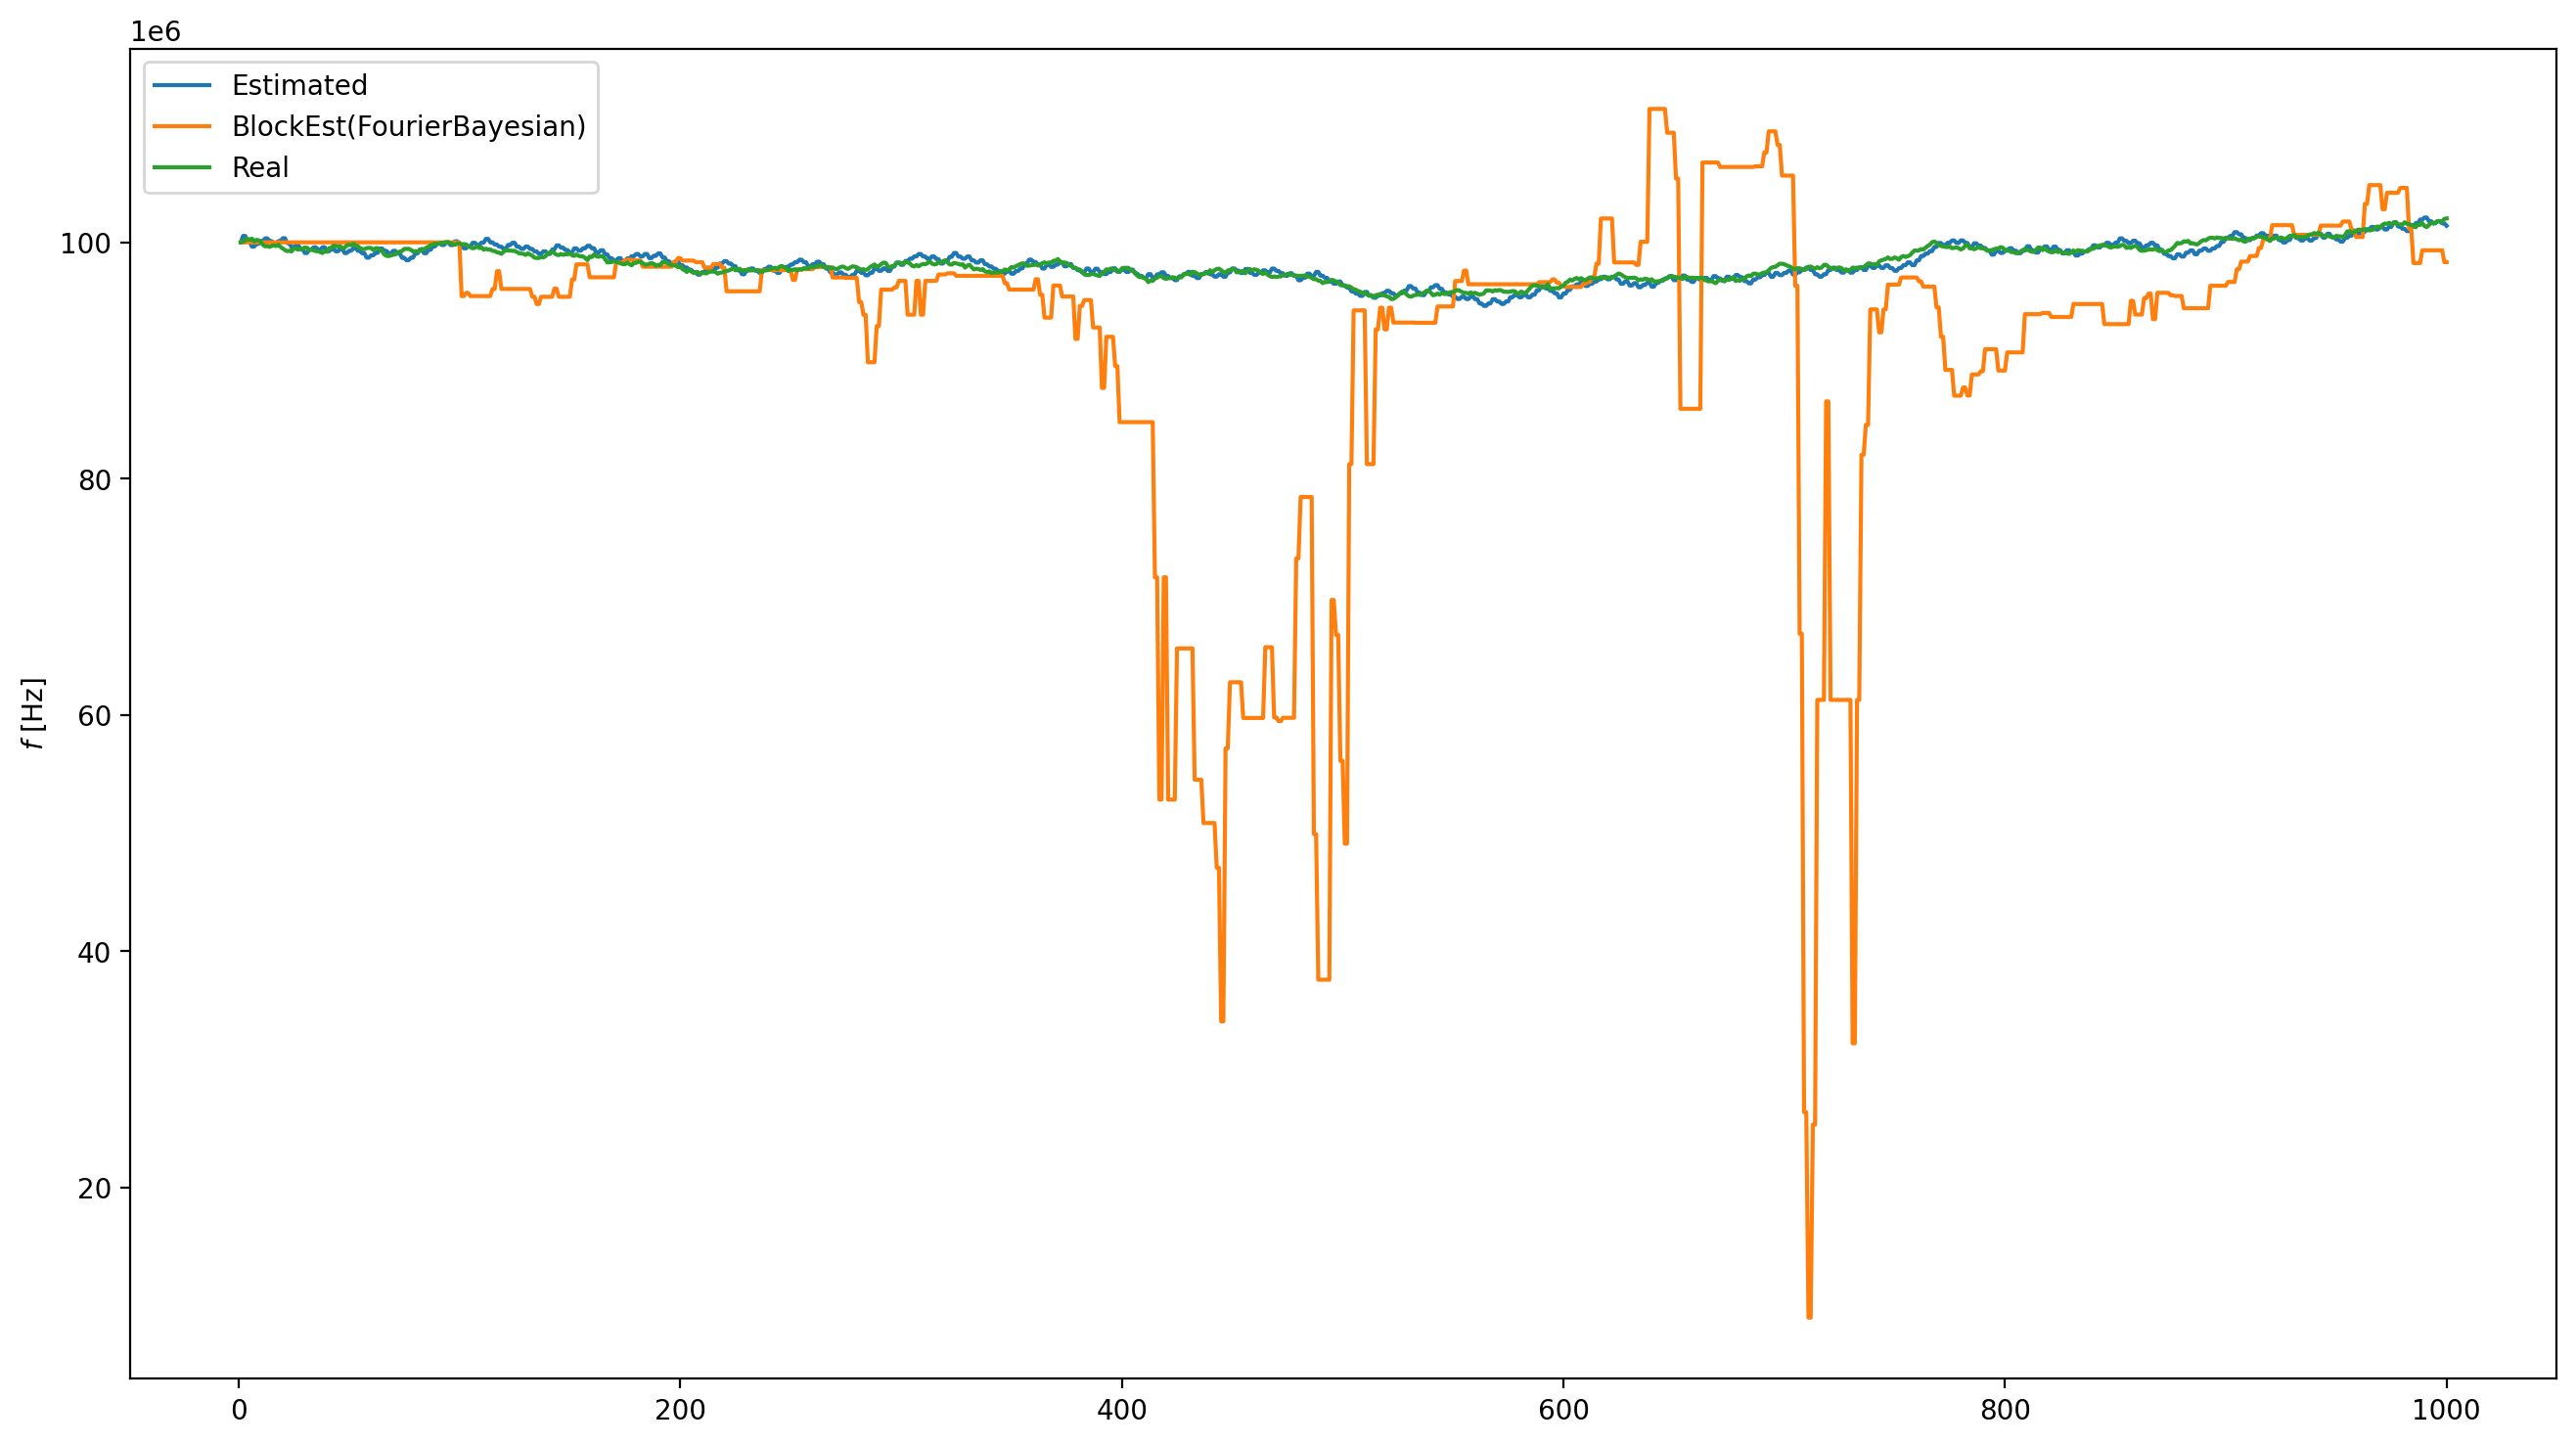

In [13]:
N = 1000

f0 = 100e6
w0 = 2 * pi * f0
tau = pi/w0/1.5
sdf0 = .115e6
sdw = 2 * pi * sdf0
alpha = 0.25
beta = 0.67

w = 2 * pi * f0
mu = 2 * pi * f0
block_mu = 2 * pi * f0
init_sdf = 1e6
var = (init_sdf*2*pi)**2

tl = []
rl = []
fl = []
block_fl = []
realfl = []
fsdl = []

msew = 0
block_msew = 0

block_size = 50
block_count = 0
block_ml = []
block_tl = []
block_rl = []

def toss(t):
    p = .5*(1 + alpha + beta * cos(w * t))
    return np.random.choice([1, -1], p=[p, 1-p])


def tripoly1sample(r, m):
    lst = [0] * (2*m + 1)
    lst[0] = r * beta * 1/2
    lst[2*m] = r * beta * 1/2
    lst[m] = 1 + alpha
    
    return np.poly1d(lst)

for _ in (range(N)):
    if _%2 != 0:
        k = round(mu/pi/sqrt(var)+.5)
        t = (k+.5)*pi/mu
        r = toss(t)

        e = exp(-.5*var*t**2)

        new_mu = mu - (r * beta * var * t * sin(mu*t) * e)/(1 + r * alpha + r * beta * cos(mu*t) * e)
        new_var = var - r * beta * var**2 * t**2 * e * ((1+r*alpha)*cos(mu*t) + r*beta*e)/(1+r*alpha + r*beta*cos(mu*t)*e)**2

        mu = new_mu
        var = new_var + (sdw ** 2) * 5
        
#         if np.abs(mu - block_mu) > 5*1e6*2*pi:
#             print(f"Ouch: {_}")
#             mu = block_mu
    
    else:
        block_count %= block_size
        
        if len(block_tl) >= block_size:
        # if len(block_tl) == block_size:    
            tripolyN = 1
            for m, r in zip (block_ml, block_rl):
                tripolyN *= tripoly1sample(r, m)
        
            coeff = tripolyN.c
            M = (len(coeff)-1)//2
            coeff = np.divide(coeff, coeff[M])

            coeff_avg = []
            for n in range(-M, M+1):
                if n == 0:
                    coeff_avg.append(pi/2)
                else:
                    coeff_avg.append(((-1)**n-1)/n**2/pi)
                    
            coeff_sqavg = []
            for n in range(-M, M+1):
                if n == 0:
                    coeff_sqavg.append(pi**2/3)
                else:
                    coeff_sqavg.append((-1)**n*2/n**2)
                    
            avg = np.dot(coeff, coeff_avg)/2/pi/tau
            sqavg = np.dot(coeff, coeff_sqavg)/(2*pi*tau)**2
            sd = sqrt(sqavg-avg**2)
            
            block_mu = avg*2*pi
            
            block_ml.pop(0)
            block_tl.pop(0)
            block_rl.pop(0)
#             block_ml = []
#             block_tl = []
#             block_rl = []
            
        m = round((1.1)**block_count)
        t = m * tau
        r = toss(t)
        
        block_ml.append(m)
        block_tl.append(t)
        block_rl.append(r)
        
        block_count += 1
        
    tl.append(t)
    rl.append(r)
    fl.append(mu/2/pi)
    block_fl.append(block_mu/2/pi)
    realfl.append(w/2/pi)
    fsdl.append(sqrt(var)/2/pi)
    msew += (w-mu)**2
    block_msew += (block_mu-w)**2
    
    w += np.random.normal(scale=sdw)
    
print(f"Avg: {mu/2/pi/1e6}")
print(f"Std: {sqrt(var)/2/pi/1e6}")
print(f"MSE: {sqrt(msew/N)/2/pi/1e6}")
print(f"BlockMSE: {sqrt(block_msew/N)/2/pi/1e6}")

# plt.plot(range(len(tl)), tl, 'o')
# plt.ticklabel_format(axis='y', scilimits=(-9, -9))
# plt.ylabel("$t$ [s]")
# plt.show()
plt.figure(figsize=(16, 9), dpi=200)
plt.plot(range(1, N+1), fl, label='Estimated')
plt.plot(range(1, N+1), block_fl, label='BlockEst(FourierBayesian)')
plt.plot(range(1, N+1), realfl, label='Real')
plt.legend()
plt.ticklabel_format(axis='y', scilimits=(6, 6))
plt.ylabel("$f$ [Hz]")
plt.show()
# plt.plot(range(1, N+1), fsdl)
# plt.ticklabel_format(axis='y', scilimits=(6, 6))
# plt.ylabel("$\sigma$ [Hz]")
# plt.show()

## Hybrid Bayesian #4

- Block Bayesian with exponential decay + Opt Bayesian[2]

Avg: 102.3856801843725
Std: 0.9253745364239445
MSE: 2.2385644281068084
BlockMSE: 1.6729323315749245


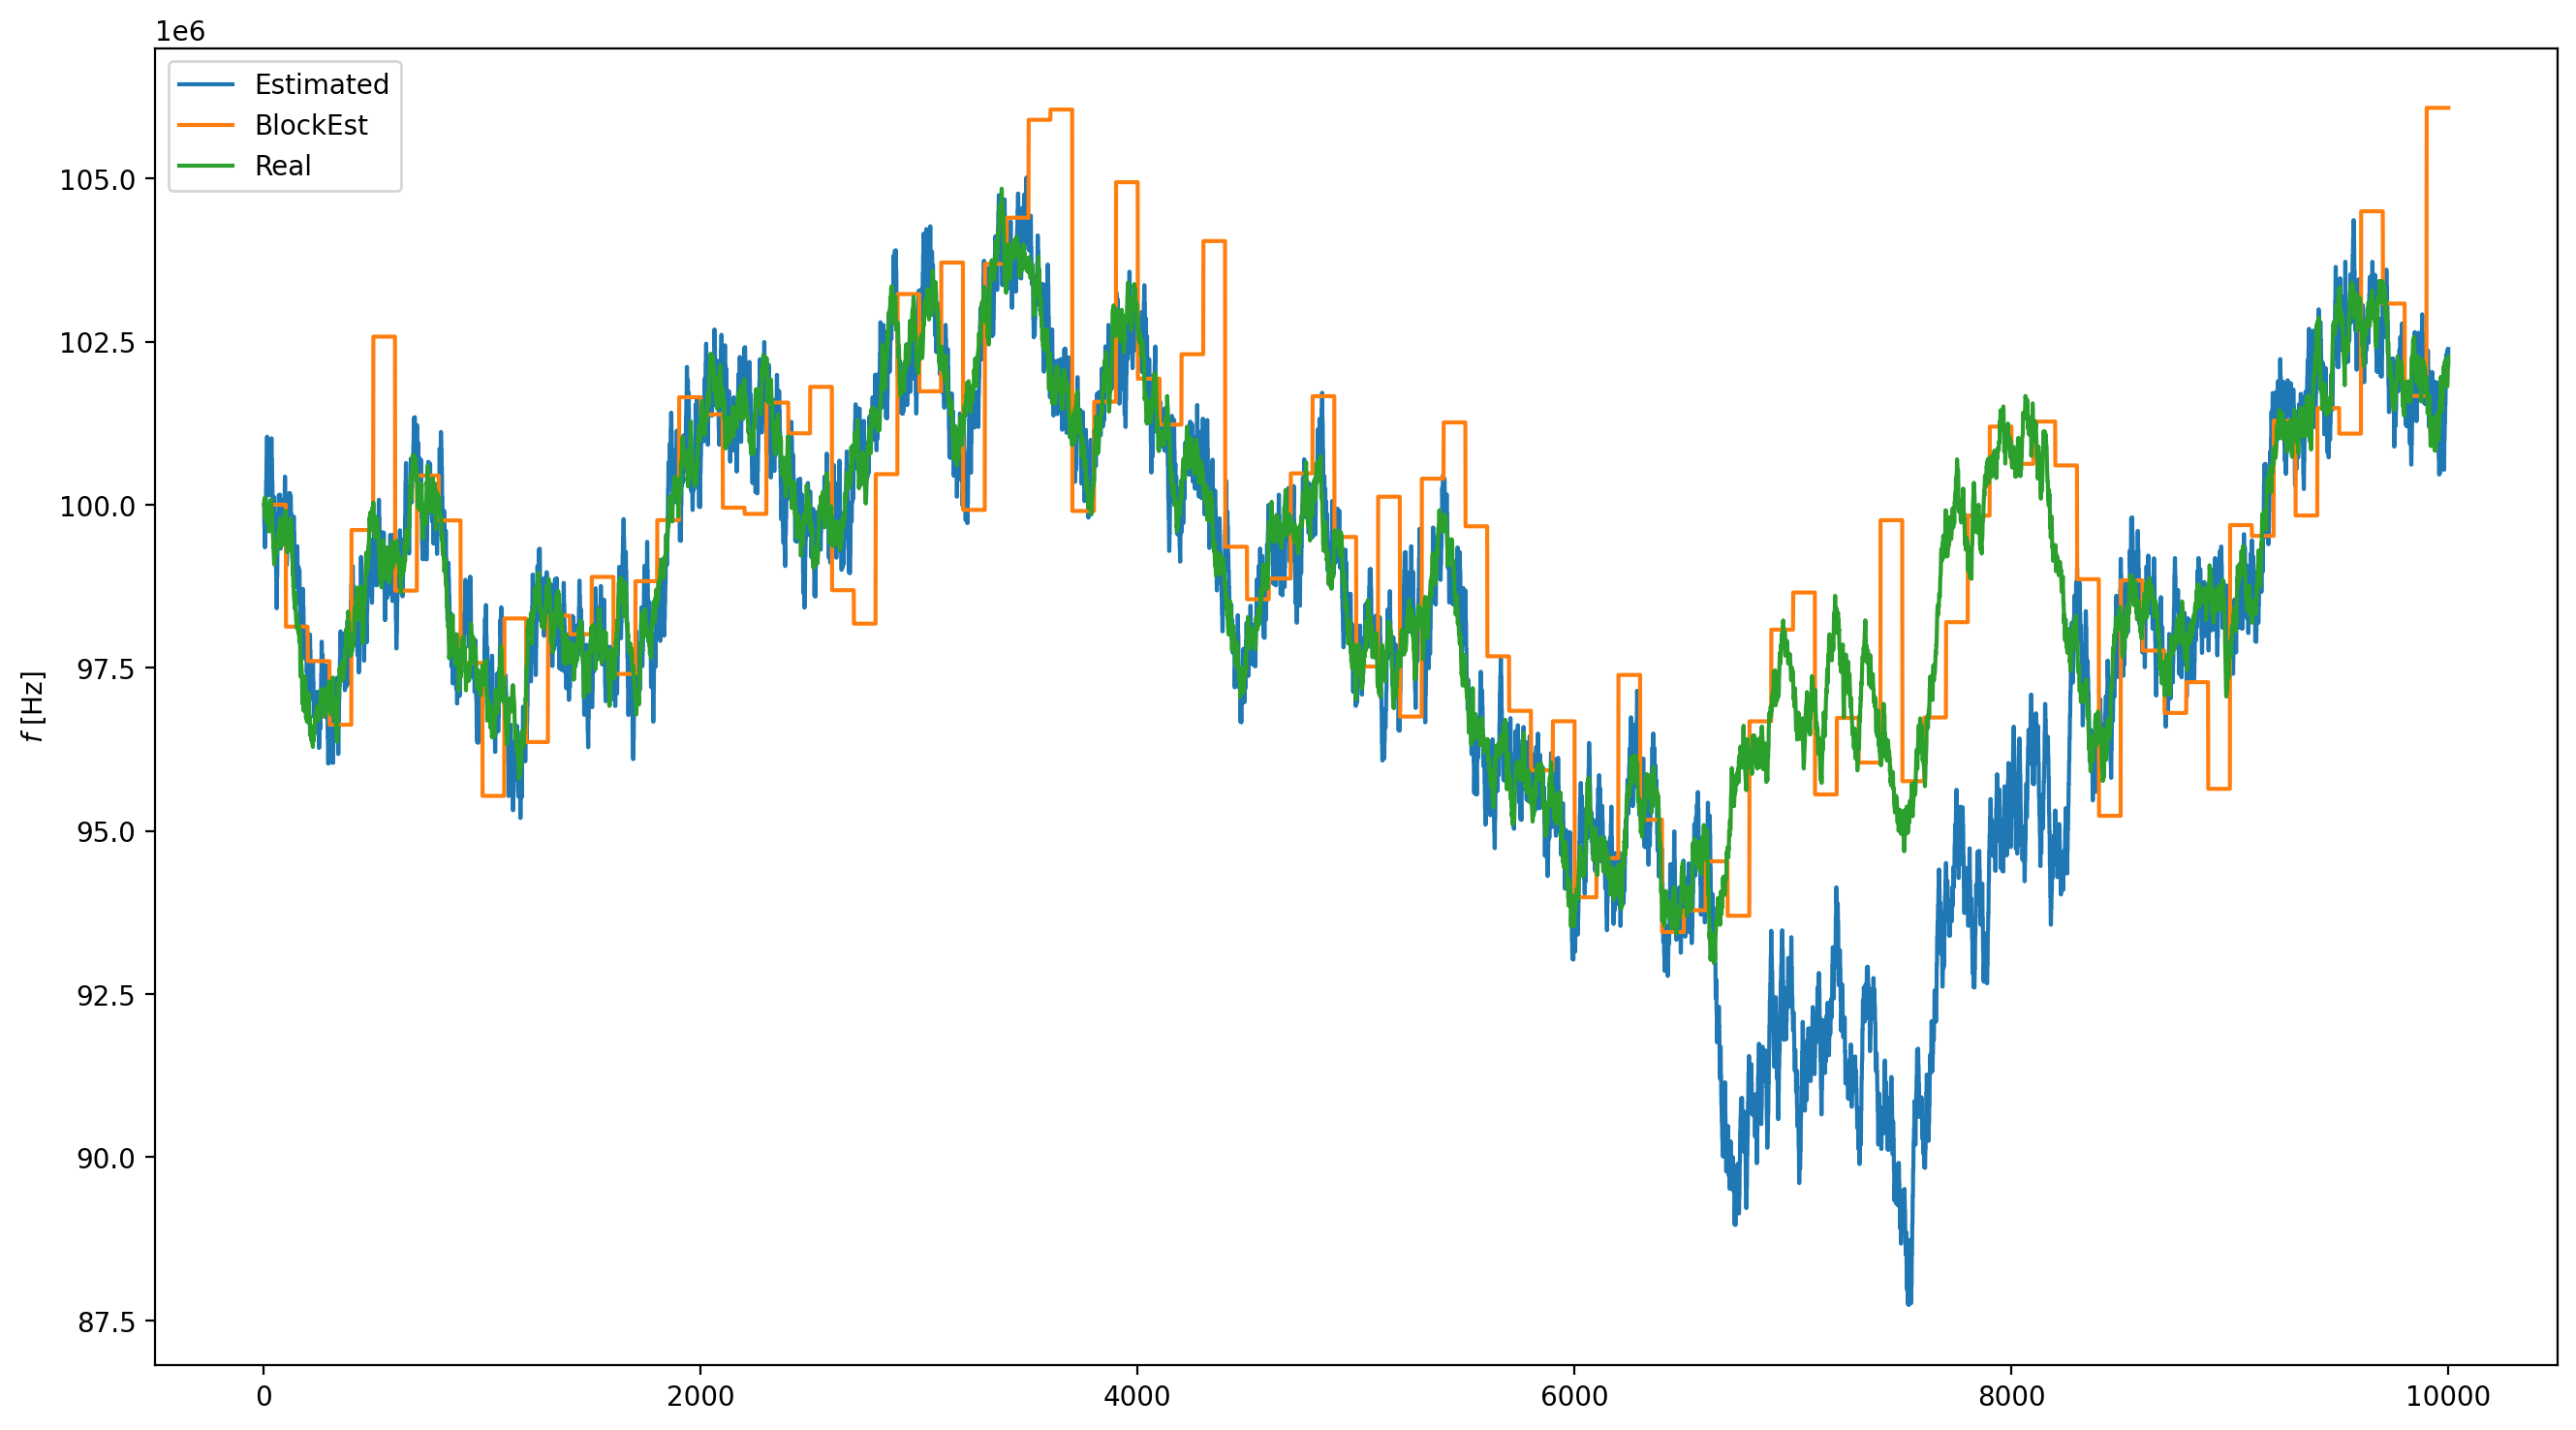

In [14]:
N = 10000

f0 = 100e6
w0 = 2 * pi * f0
sdf0 = .115e6
sdw = 2 * pi * sdf0
alpha = 0.25
beta = 0.67

def toss(t):
    p = .5*(1 + alpha + beta * cos(w * t))
    return np.random.choice([1, -1], p=[p, 1-p])

w = 2 * pi * f0
mu = 2 * pi * f0
block_mu = 2 * pi * f0
init_sdf = 1e6
var = (init_sdf*2*pi)**2

tl = []
rl = []
fl = []
block_fl = []
realfl = []
fsdl = []

msew = 0
block_msew = 0

M = 50
block_count = 0
block_tl = []
block_rl = []

for _ in range(N):
    if _%2 != 0:
        k = round(mu/pi/sqrt(var)+.5)
        t = (k+.5)*pi/mu
        r = toss(t)

        e = exp(-.5*var*t**2)

        new_mu = mu - (r * beta * var * t * sin(mu*t) * e)/(1 + r * alpha + r * beta * cos(mu*t) * e)
        new_var = var - r * beta * var**2 * t**2 * e * ((1+r*alpha)*cos(mu*t) + r*beta*e)/(1+r*alpha + r*beta*cos(mu*t)*e)**2

        mu = new_mu
        var = new_var + (sdw ** 2) * 10
        
#         if np.abs(mu - block_mu) > 5*1e6*2*pi:
#             print(f"Ouch: {_}")
#             mu = block_mu
    
    else:
        block_count %= M
        if len(block_tl) == M:
            def posterior(w):
                res = 1
                for t, r, i in zip(block_tl, block_rl, range(M)):
                    j = M-i
                    res *= (1+r*(alpha+beta*cos(w*t)*exp(-.5*(j*sdw*t)**2)))
                return res
        
            block_mu = minimize(lambda x: -posterior(x), block_mu, method='Powell').x[0]
            block_tl = []
            block_rl = []
            
        t = block_count % 100 * 1e-9
        r = toss(t)
        
        block_tl.append(t)
        block_rl.append(r)
        
        block_count += 1
        
    tl.append(t)
    rl.append(r)
    fl.append(mu/2/pi)
    block_fl.append(block_mu/2/pi)
    realfl.append(w/2/pi)
    fsdl.append(sqrt(var)/2/pi)
    
    msew += (w-mu)**2
    block_msew += (block_mu-w)**2
    
    w += np.random.normal(scale=sdw)
    
print(f"Avg: {mu/2/pi/1e6}")
print(f"Std: {sqrt(var)/2/pi/1e6}")
print(f"MSE: {sqrt(msew/N)/2/pi/1e6}")
print(f"BlockMSE: {sqrt(block_msew/N)/2/pi/1e6}")

# plt.plot(range(len(tl)), tl, 'o')
# plt.ticklabel_format(axis='y', scilimits=(-9, -9))
# plt.ylabel("$t$ [s]")
# plt.show()
plt.figure(figsize=(16, 9), dpi=200)
plt.plot(range(1, N+1), fl, label='Estimated')
plt.plot(range(1, N+1), block_fl, label='BlockEst')
plt.plot(range(1, N+1), realfl, label='Real')
plt.legend()
plt.ticklabel_format(axis='y', scilimits=(6, 6))
plt.ylabel("$f$ [Hz]")
plt.show()
# plt.plot(range(1, N+1), fsdl)
# plt.ticklabel_format(axis='y', scilimits=(6, 6))
# plt.ylabel("$\sigma$ [Hz]")
# plt.show()

## Hybrid Bayesian #5

- Opt Bayesian + Opt Bayesian[2]

MSE1: 0.5483389438744001
MSE2: 0.3994798728447019
MSE3: 0.3382886073899778


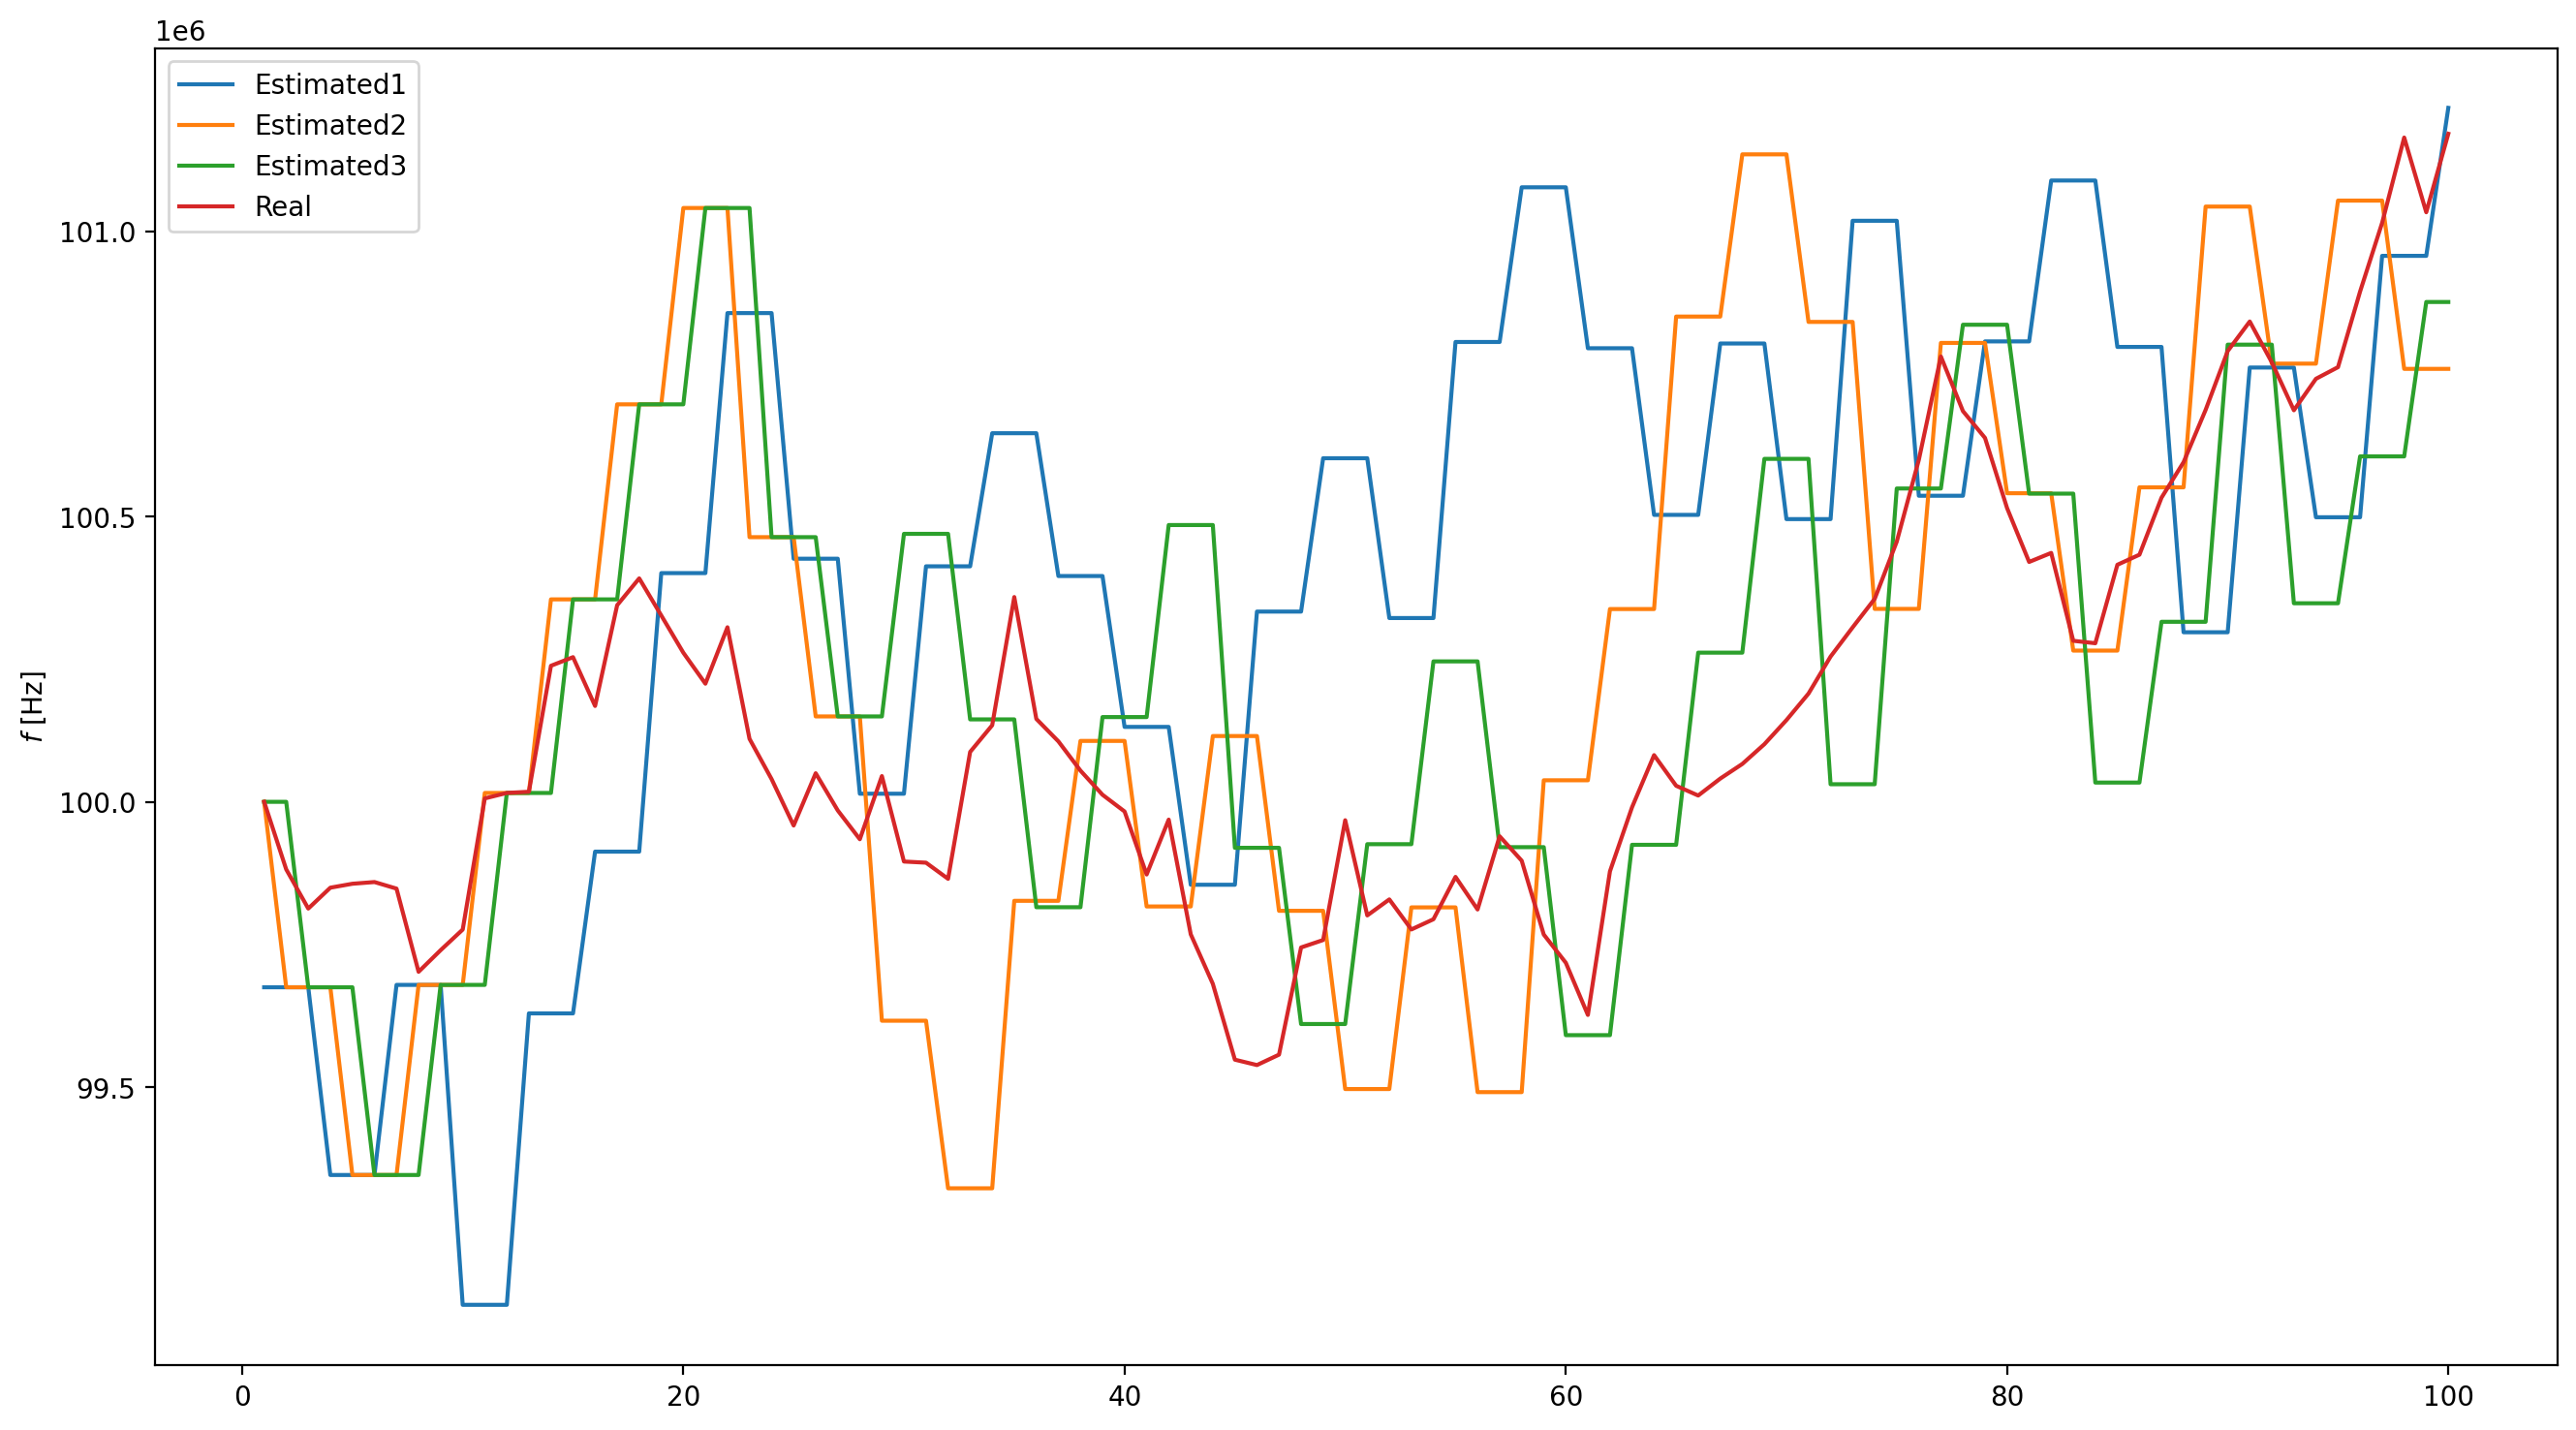

In [15]:
N = 100

f0 = 100e6
w0 = 2 * pi * f0
sdf0 = .115e6
sdw = 2 * pi * sdf0
alpha = 0.25
beta = 0.67

def toss(t):
    p = .5*(1 + alpha + beta * cos(w * t))
    return np.random.choice([1, -1], p=[p, 1-p])

w = 2 * pi * f0
mu1 = 2 * pi * f0
mu2 = 2 * pi * f0
mu3 = 2 * pi * f0
init_sdf = 1e6
var1 = (init_sdf*2*pi)**2
var2 = (init_sdf*2*pi)**2
var3 = (init_sdf*2*pi)**2

fl1 = []
fl2 = []
fl3 = []
realfl = []

msew1 = 0
msew2 = 0
msew3 = 0

popcorn = 10

for _ in range(N):
    if _%3 == 0:
        k = round(mu1/pi/sqrt(var1)+.5)
        t = (k+.5)*pi/mu1
        r = toss(t)
        
        e = exp(-.5*var1*t**2)
        
        new_mu1 = mu1 - (r * beta * var1 * t * sin(mu1*t) * e)/(1 + r * alpha + r * beta * cos(mu1*t) * e)
        new_var1 = var1 - r * beta * var1**2 * t**2 * e * ((1+r*alpha)*cos(mu1*t) + r*beta*e)/(1+r*alpha + r*beta*cos(mu1*t)*e)**2
        
        mu1 = new_mu1
        var1 = new_var1 + (sdw ** 2) * popcorn
    
    elif _%3 == 1:
        k = round(mu2/pi/sqrt(var2)+.5)
        t = (k+.5)*pi/mu2
        r = toss(t)
        
        e = exp(-.5*var2*t**2)
        
        new_mu2 = mu2 - (r * beta * var2 * t * sin(mu2*t) * e)/(1 + r * alpha + r * beta * cos(mu2*t) * e)
        new_var2 = var2 - r * beta * var2**2 * t**2 * e * ((1+r*alpha)*cos(mu2*t) + r*beta*e)/(1+r*alpha + r*beta*cos(mu2*t)*e)**2
        
        mu2 = new_mu2
        var2 = new_var2 + (sdw ** 2) * popcorn
        
    else:
        k = round(mu3/pi/sqrt(var3)+.5)
        t = (k+.5)*pi/mu3
        r = toss(t)
        
        e = exp(-.5*var3*t**2)
        
        new_mu3 = mu3 - (r * beta * var3 * t * sin(mu3*t) * e)/(1 + r * alpha + r * beta * cos(mu3*t) * e)
        new_var3 = var3 - r * beta * var3**2 * t**2 * e * ((1+r*alpha)*cos(mu3*t) + r*beta*e)/(1+r*alpha + r*beta*cos(mu3*t)*e)**2
        
        mu3 = new_mu3
        var3 = new_var3 + (sdw ** 2) * popcorn
    
    fl1.append(mu1/2/pi)
    fl2.append(mu2/2/pi)
    fl3.append(mu3/2/pi)
    realfl.append(w/2/pi)
    
    
    msew1 += (w-mu1)**2
    msew2 += (w-mu2)**2
    msew3 += (w-mu3)**2
    w += np.random.normal(scale=sdw)
    
print(f"MSE1: {sqrt(msew1/N)/2/pi/1e6}")
print(f"MSE2: {sqrt(msew2/N)/2/pi/1e6}")
print(f"MSE3: {sqrt(msew3/N)/2/pi/1e6}")


# plt.plot(range(len(tl)), tl, 'o')
# plt.ticklabel_format(axis='y', scilimits=(-9, -9))
# plt.ylabel("$t$ [s]")
# plt.show()
plt.figure(figsize=(16, 9), dpi=200)
plt.plot(range(1, N+1), fl1, label='Estimated1')
plt.plot(range(1, N+1), fl2, label='Estimated2')
plt.plot(range(1, N+1), fl3, label='Estimated3')
plt.plot(range(1, N+1), realfl, label='Real')
plt.legend()
plt.ticklabel_format(axis='y', scilimits=(6, 6))
plt.ylabel("$f$ [Hz]")
plt.show()
# plt.plot(range(1, N+1), fsdl)
# plt.ticklabel_format(axis='y', scilimits=(6, 6))
# plt.ylabel("$\sigma$ [Hz]")
# plt.show()

## Revised Hybrid Bayesian #2

- Parameters: popcorn, ouch, ratio: block/optbaysian, minimizing range and precision 

100%|██████████| 50000/50000 [00:45<00:00, 1091.91it/s]


Avg: 77.5747MHz
Std: 0.6000MHz
Total MSE: 0.8396MHz
Lower MSE: 0.3721MHz
Block MSE: 1.3739MHz


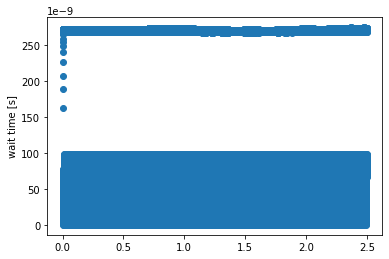

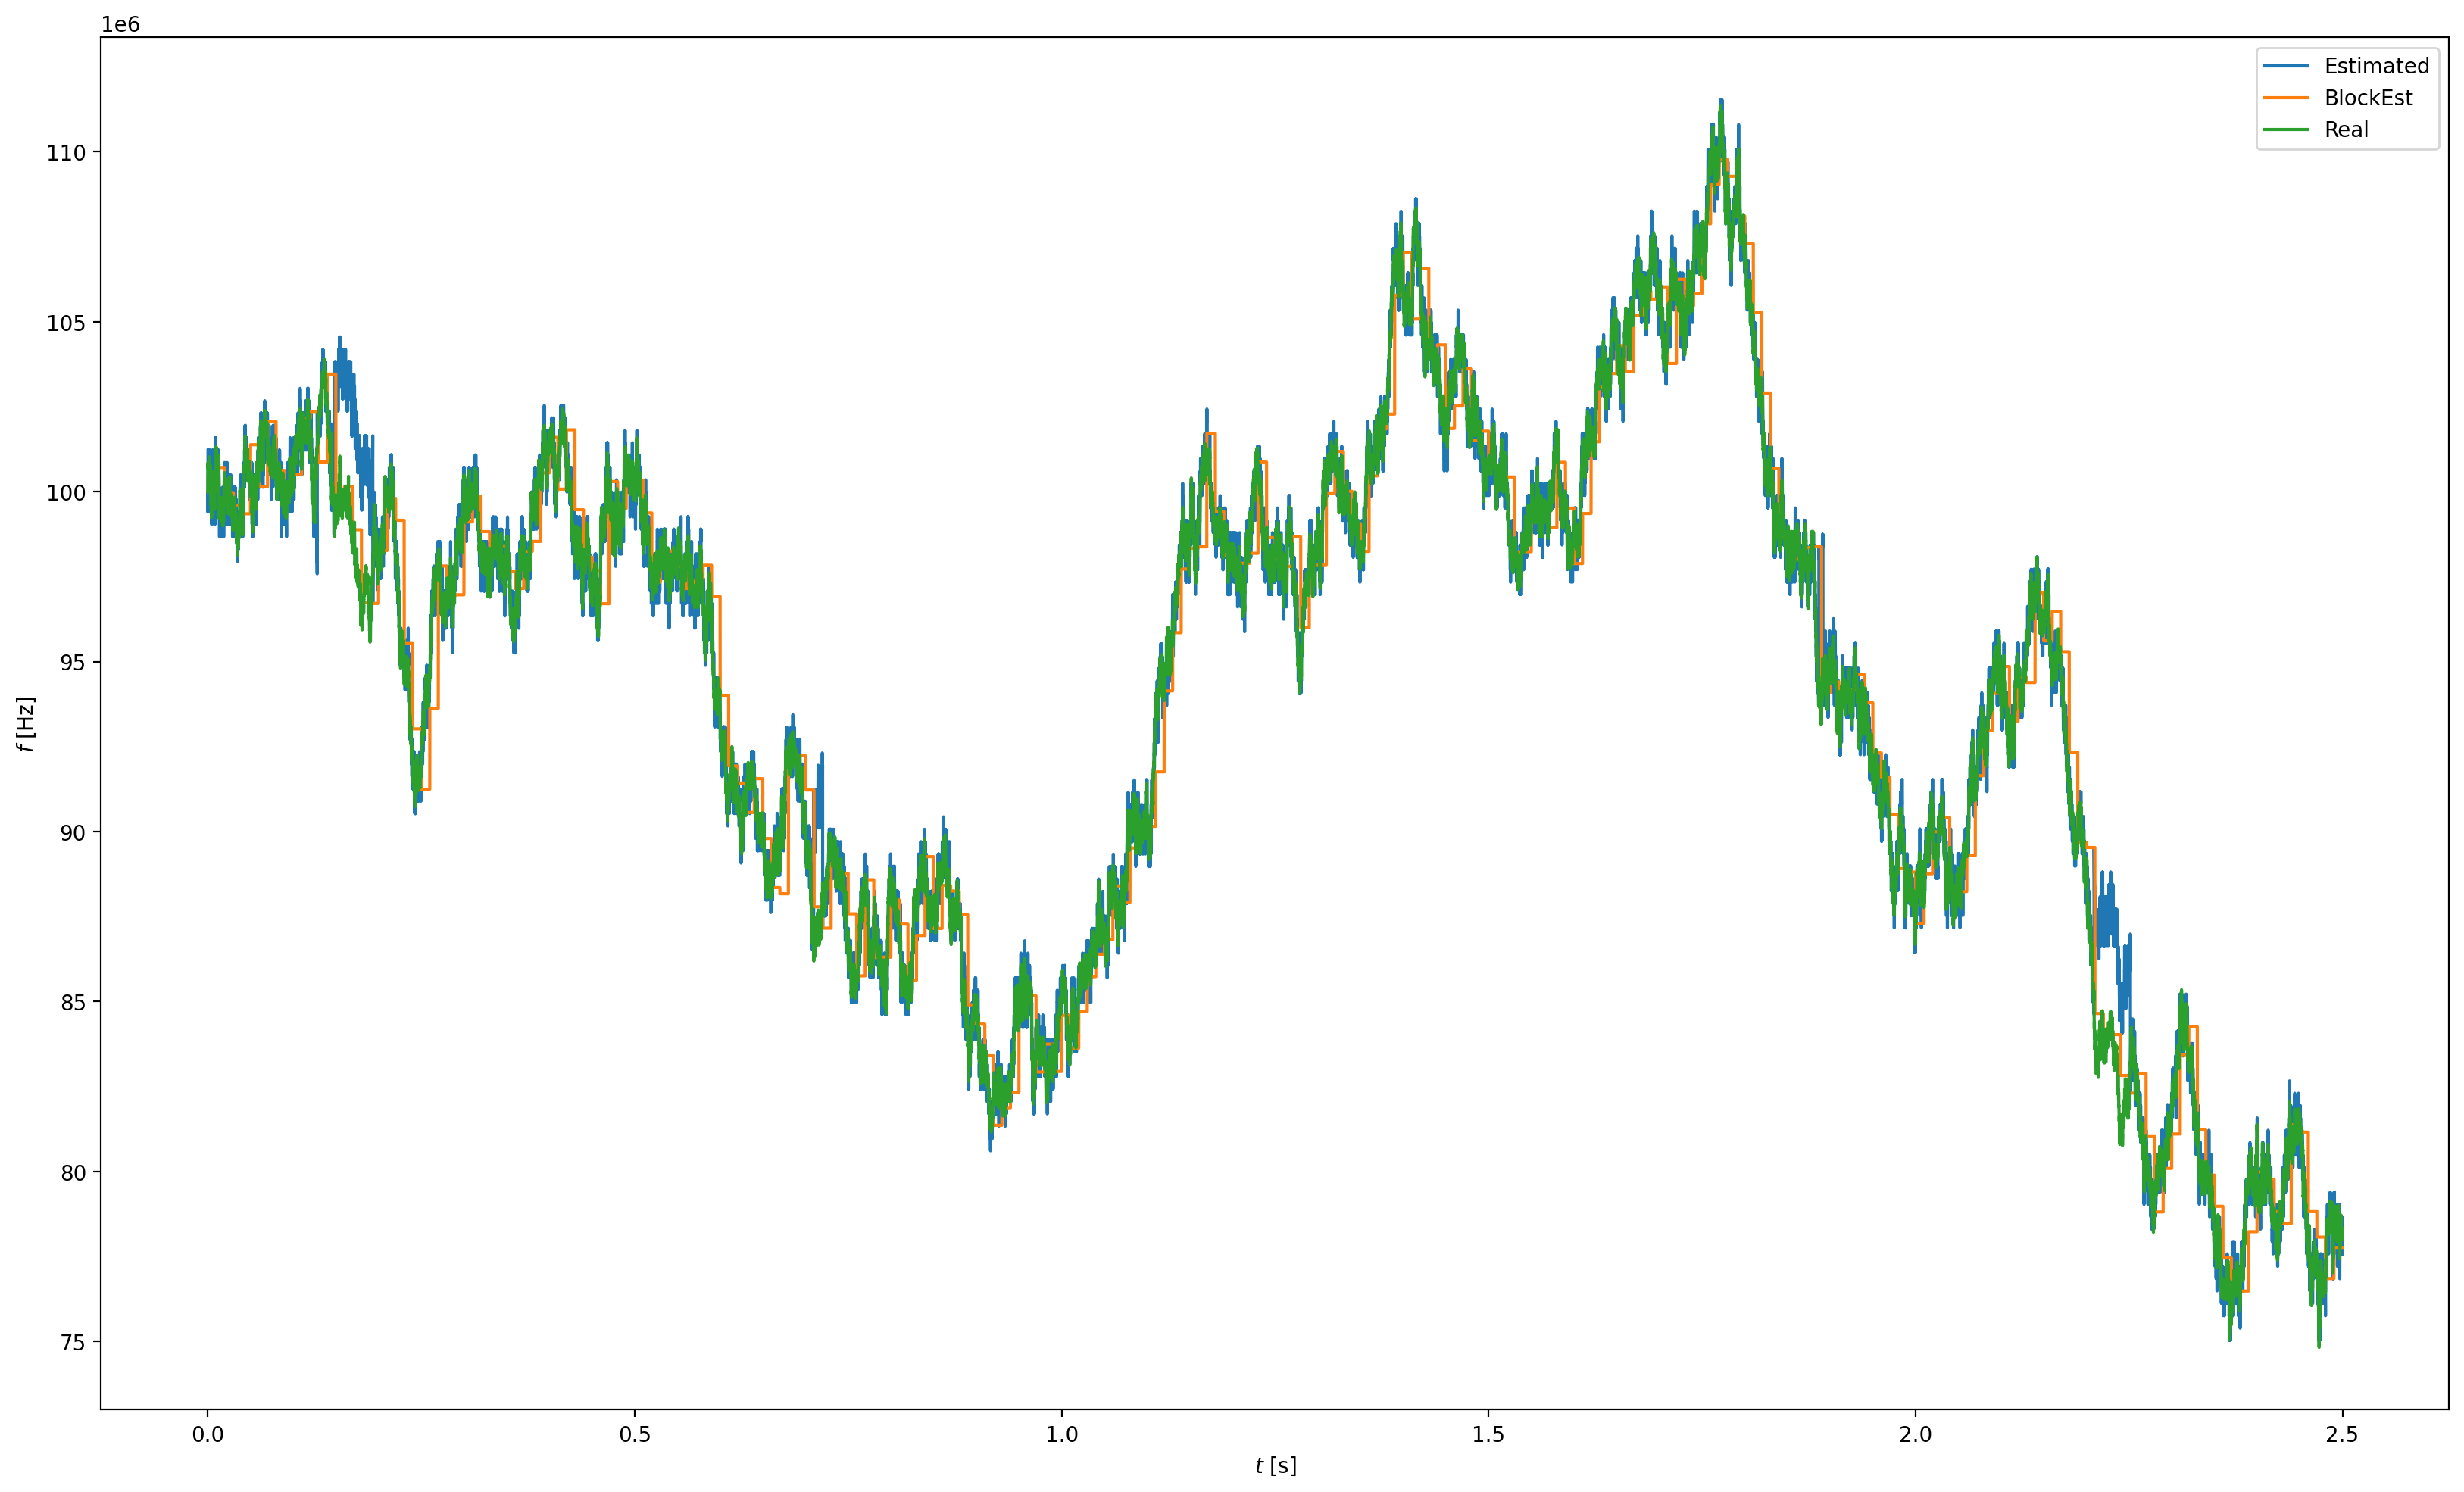

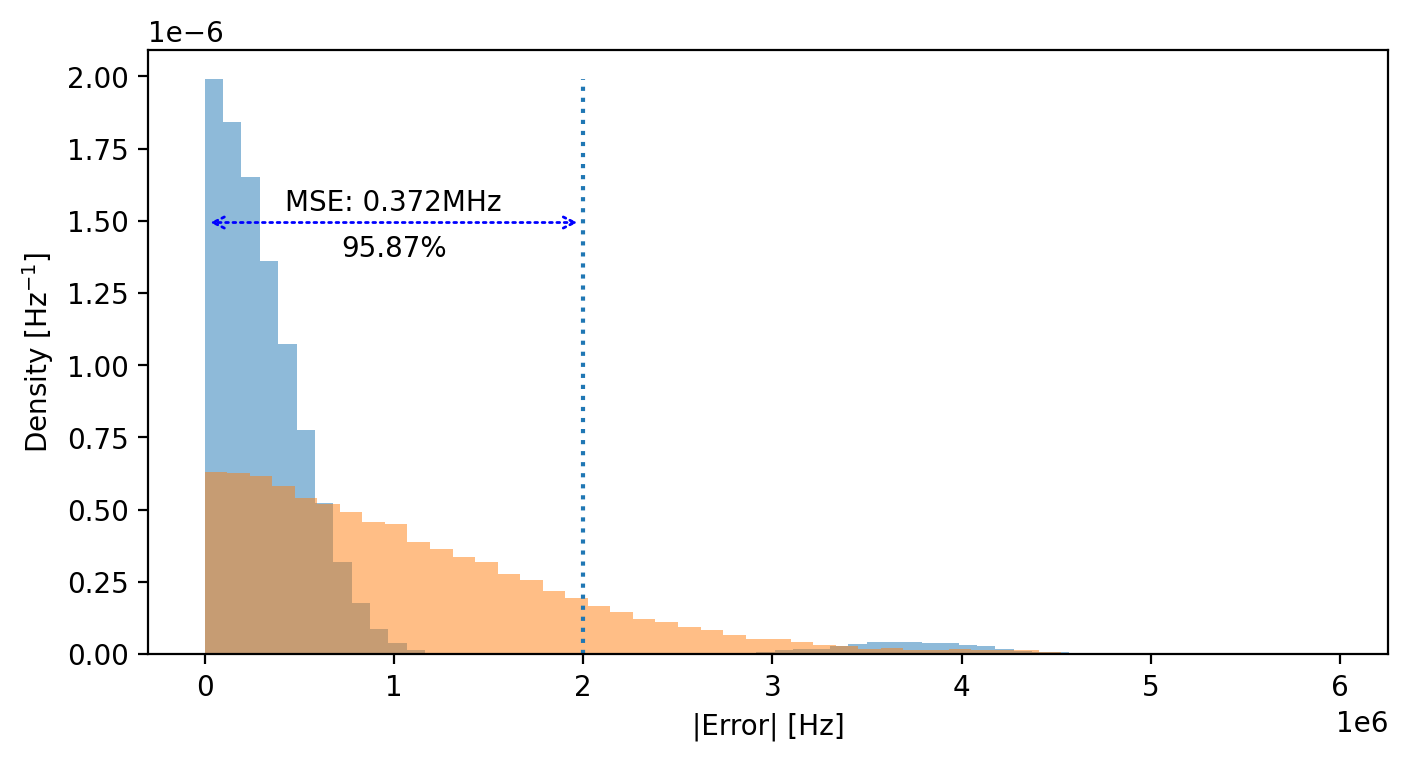

In [33]:
N = 50000

f0 = 100e6
w0 = 2 * pi * f0
sdf0 = .115e6
sdw = 2 * pi * sdf0
alpha = 0
beta = 1

def toss(t):
    p = .5*(1 + alpha + beta * cos(w * t))
    return np.random.choice([1, -1], p=[p, 1-p])

def posterior(w):
    res = 1
    for t, r in zip(block_tl, block_rl):
        res *= (1+r*(alpha+beta*cos(w*t)))
    #res *= scipy.stats.norm(loc=block_mu, scale=SD_w).pdf(w)
    return res

def brute_maximize(func, initial_guess):
    rge = 50e6
    precision = 1000
    lst = np.linspace(initial_guess-rge, initial_guess+rge, precision)
    
    with Pool() as p:
        res = p.map(func, lst)
    return lst[np.argmax(res)]

w = 2 * pi * f0
mu = 2 * pi * f0
block_mu = 2 * pi * f0
init_sdf = 1e6
var = (init_sdf*2*pi)**2

tl = []
rl = []
fl = []
block_fl = []
realfl = []
fsdl = []

msew = 0
msewl = []
block_msew = 0
block_msewl = []

M = 100
SD_w = 20e6 * 2 * pi
block_count = 0
block_tl = []
block_rl = []

tau = 50e-6

popcorn = 10
ouch = 5

for _ in tqdm(range(N)):
    if _%2 != 0:
        k = round(mu/pi/sqrt(var)+.5)
        t = (k+.5)*pi/mu
        r = toss(t)

        e = exp(-.5*var*t**2)

        new_mu = mu - (r * beta * var * t * sin(mu*t) * e)/(1 + r * alpha + r * beta * cos(mu*t) * e)
        new_var = var - r * beta * var**2 * t**2 * e * ((1+r*alpha)*cos(mu*t) + r*beta*e)/(1+r*alpha + r*beta*cos(mu*t)*e)**2

        mu = new_mu
        var = new_var + (sdw ** 2) * popcorn
        
        if np.abs(mu - block_mu) > 1e6*2*pi * ouch:
            # print(f"Ouch: {_*tau:.4}")
            mu = block_mu
    
    else:
        block_count %= M
        if len(block_tl) == M:
            
        
            block_mu = brute_maximize(posterior, block_mu)
            block_tl = []
            block_rl = []
            
        t = block_count % 100 * 1e-9
        r = toss(t)
        
        block_tl.append(t)
        block_rl.append(r)
        
        block_count += 1
        
    tl.append(t)
    rl.append(r)
    fl.append(mu/2/pi)
    block_fl.append(block_mu/2/pi)
    realfl.append(w/2/pi)
    fsdl.append(sqrt(var)/2/pi)
    
    msew = (w-mu)**2
    msewl.append(msew)
    block_msew = (w-block_mu)**2
    block_msewl.append(block_msew)
    
    w += np.random.normal(scale=sdw)
    
print(f"Avg: {mu/2/pi/1e6:.4f}MHz")
print(f"Std: {sqrt(var)/2/pi/1e6:.4f}MHz")
print(f"Total MSE: {sqrt(stats.mean(msewl))/2/pi/1e6:.4f}MHz")
print(f"Lower MSE: {sqrt(stats.mean([msew for msew in msewl if msew<(2e6*2*pi)**2]))/2/pi/1e6:.4f}MHz")

print(f"Block MSE: {sqrt(stats.mean(block_msewl))/2/pi/1e6:.4f}MHz")

time = [i*tau for i in range(1, N+1)]

plt.plot(time, tl, 'o')
plt.ticklabel_format(axis='y', scilimits=(-9, -9))
plt.ylabel("wait time [s]")
plt.show()

plt.figure(figsize=(20, 12), dpi=200)
plt.plot(time, fl, label='Estimated')
plt.plot(time, block_fl, label='BlockEst')
plt.plot(time, realfl, label='Real')
plt.legend()
plt.ticklabel_format(axis='y', scilimits=(6, 6))
plt.xlabel("$t$ [s]")
plt.ylabel("$f$ [Hz]")
plt.show()

plt.figure(figsize=(8, 4), dpi=200)
n, bins, patch = plt.hist([(sqrt(msew)/2/pi) for msew in msewl], alpha=0.5, density=True, bins=50)
plt.hist([(sqrt(msew)/2/pi) for msew in block_msewl], alpha=0.5, density=True, bins=50)
plt.ticklabel_format(axis='x', scilimits=(6, 6))
plt.vlines(2e6, 0, max(n), linestyle=":")
plt.annotate(text='', xy=(0,.75*max(n)), xytext=(2e6,.75*max(n)), arrowprops=dict(arrowstyle='<->', color='b', ls=":"))
plt.annotate(f"MSE: {sqrt(stats.mean([msew for msew in msewl if msew<(2e6*2*pi)**2]))/2/pi/1e6:.3f}MHz", xy=(1e6, .77*max(n)), ha='center')
plt.annotate(f"{sum([msew<(2e6*2*pi)**2 for msew in msewl])/len(msewl)*100:.2f}%", xy=(1e6, .69*max(n)), ha='center')
plt.xlabel("|Error| [Hz]")
plt.ylabel("Density [$\mathrm{Hz}^{-1}$]")
plt.show()

# plt.plot(range(1, N+1), fsdl)
# plt.ticklabel_format(axis='y', scilimits=(6, 6))
# plt.ylabel("$\sigma$ [Hz]")
# plt.show()

# Reference

[1] Sergeevich, A., Chandran, A., Combes, J., Bartlett, S. D., & Wiseman, H. M. (2011). Characterization of a qubit Hamiltonian using adaptive measurements in a fixed basis. Physical Review A - Atomic, Molecular, and Optical Physics, 84(5), 052315. https://doi.org/10.1103/PhysRevA.84.052315

[2] Ferrie, C., Granade, C. E., & Cory, D. G. (2013). How to best sample a periodic probability distribution, or on the accuracy of Hamiltonian finding strategies. Quantum Information Processing 2012 12:1, 12(1), 611–623. https://doi.org/10.1007/S11128-012-0407-6